<a href="https://colab.research.google.com/github/nurayuasyifa/credit-risk-analysis-and-prediction/blob/main/Machine_Learning_to_Predict_Credit_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Understanding

- projek dari sebuah lending company
- membangun model yang dapat memprediksi credit risk 
- menggunakan dataset yang disediakan oleh company yang terdiri dari **data pinjaman yang diterima dan yang ditolak**.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_columns',None)

In [ ]:
loan = pd.read_csv('https://rakamin-lms.s3.ap-southeast-1.amazonaws.com/vix-assets/idx-partners/loan_data_2007_2014.csv',low_memory=False)

In [ ]:
loan.shape

(466285, 75)

In [ ]:
loan.drop(columns='Unnamed: 0',inplace=True)

In [ ]:
loan1 = loan.copy()

bad debt :
* Charged off
* Default
* Late (31-120 days)
* Late (16-30 days)
* Does not meet the credit policy. Status:Charged Off

good debt:
* In Grace Period
* Fully Paid
* Current
* Does not meet the credit policy. Status:Fully Paid

In [ ]:
# membuat feature target
loan1['target'] = np.where((loan1['loan_status'] =='Charged Off') | 
                         (loan1['loan_status'] =='Default') | 
                         (loan1['loan_status'] =='Late (31-120 days)') | 
                         (loan1['loan_status'] =='Late (16-30 days)') | 
                         (loan1['loan_status'] =='Does not meet the credit policy. Status:Charged Off'),1,0)

In [ ]:
dfg = loan1.groupby('target').agg({'id':'count'}).reset_index()
dfg.columns = ['target','total']
dfg['%'] = round(dfg['total']*100/sum(dfg['total']),3)
dfg

,target,total,%
0,0,414099,88.808
1,1,52186,11.192


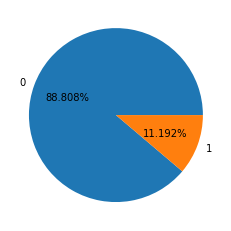

In [ ]:
plt.pie(dfg['total'],labels=dfg['target'], autopct='%.3f%%')
plt.show()

Berdasarkan tabel diatas persentase `bad debt rate = 11.192%`. Pembuatan model machine learning bertujuan untuk menurunkan `default rate` hingga `<5%`.


In [ ]:
loan1.groupby('target').agg({'funded_amnt':'sum','total_pymnt':'sum'}).reset_index()

,target,funded_amnt,total_pymnt
0,0,5903136300,5.014684e+09
1,1,760916150,3.665645e+08


Perusahaan loss sebesar $760,916,150 karena 11.192% peminjam tidak mampu bayar

# Data Collection

feature yang semua nilainya null di drop untuk memudahkan proses selanjutnya 

In [ ]:
to_drop = loan1.isnull().sum().sort_values()
to_drop = to_drop[to_drop == loan1.shape[0]]
to_drop = list(to_drop.index)

#check dimensi dataset
print('dimensi dataset sebelum drop = ',loan1.shape)

#drop feature yang semua isinya nilai null
loan1.drop(columns=to_drop,inplace=True)

#check dimensi dataset
print('dimensi dataset setelah drop = ',loan1.shape)

dimensi dataset sebelum drop =  (466285, 75)
dimensi dataset setelah drop =  (466285, 58)


In [ ]:
# memisahkan feature numerical dengan categorical
nums = []
cats = []
for i in loan1.columns:
  if loan1[i].dtype == 'object':
    cats.append(i)
  else:
    nums.append(i)
print('jumlah = ',len(nums))
print('nums = ',nums)
print('jumlah = ',len(cats))
print('cats = ',cats)

jumlah =  36
nums =  ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'target']
jumlah =  22
cats =  ['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type']


In [ ]:
loan1['funded_amnt'][loan1['target']==1].sum()

760916150

## **Statistical Summary For Categorical Features**

In [ ]:
loan1[cats].describe().transpose()

,count,unique,top,freq
term,466285,2,36 months,337953
grade,466285,7,B,136929
sub_grade,466285,35,B3,31686
emp_title,438697,205475,Teacher,5399
emp_length,445277,11,10+ years,150049
home_ownership,466285,6,MORTGAGE,235875
verification_status,466285,3,Verified,168055
issue_d,466285,91,Oct-14,38782
loan_status,466285,9,Current,224226
pymnt_plan,466285,2,n,466276


**Observasi:**
* Features `emp_title`,`url`,`desc`,`title`,`zip_code`,`addr_state` tidak akan digunakan karena terlalu banyak nilai yang unik
* Feature `application_type` juga tidak akan digunakan karena hanya memiliki 1 nilai unik, sehingga tidak ada informasi yang dapat diperoleh dari feature tersebut.

In [ ]:
#check dimensi dataset
print('dimensi dataset sebelum drop = ',loan1.shape)

#drop
loan1.drop(columns=['emp_title','url','desc','title','zip_code','addr_state','application_type'],inplace=True)

#check dimensi dataset
print('dimensi dataset setelah drop = ',loan1.shape)

dimensi dataset sebelum drop =  (466285, 58)
dimensi dataset setelah drop =  (466285, 51)


## **Statistical Summary for Numerical Features**

In [ ]:
loan1[nums].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,466285.0,1.307973e+07,1.089371e+07,54734.00,3.639987e+06,1.010790e+07,2.073121e+07,3.809811e+07
member_id,466285.0,1.459766e+07,1.168237e+07,70473.00,4.379705e+06,1.194108e+07,2.300154e+07,4.086083e+07
loan_amnt,466285.0,1.431728e+04,8.286509e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt,466285.0,1.429180e+04,8.274371e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt_inv,466285.0,1.422233e+04,8.297638e+03,0.00,8.000000e+03,1.200000e+04,1.995000e+04,3.500000e+04
int_rate,466285.0,1.382924e+01,4.357587e+00,5.42,1.099000e+01,1.366000e+01,1.649000e+01,2.606000e+01
installment,466285.0,4.320612e+02,2.434855e+02,15.67,2.566900e+02,3.798900e+02,5.665800e+02,1.409990e+03
annual_inc,466281.0,7.327738e+04,5.496357e+04,1896.00,4.500000e+04,6.300000e+04,8.896000e+04,7.500000e+06
dti,466285.0,1.721876e+01,7.851121e+00,0.00,1.136000e+01,1.687000e+01,2.278000e+01,3.999000e+01
delinq_2yrs,466256.0,2.846784e-01,7.973651e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,2.900000e+01


**Keterangan:**
* `id` adalah ID yang ditetapkan LC unik untuk daftar pinjaman
* `member_id` adalah ID unik yang ditetapkan LC untuk anggota peminjam
* `loan_amnt` jumlah yang diajukan oleh peminjam
* `funded_amnt` jumlah yg diberikan kepada peminjam
* `funded_amnt_inv` jumlah yang diberikan investor untuk peminjam
* `int_rate` bunga pinjaman

* `annual_inc` adalah income tahunan peminjam
* `dti` adalah rasio antara pinjaman dengan income
* `delinq_2yrs` adalah Jumlah insiden tunggakan 30 hari dalam arsip kredit peminjam selama 2 tahun terakhir
*  `inq_last_6mnths` adalah jumlah penyelidikan selama 6 bulan terakhir (kecuali mobil dan hipotek)
*  `mths_since_last_delinq` adalah Jumlah bulan sejak tunggakan terakhir peminjam.
* `mths_since_last_record` adalah Jumlah bulan sejak catatan publik terakhir

* `pub_rec` adalah jumlah catatan publik yg jatuh tempo
* `revol_bal` adalah total saldo kredit revolving (porsi pengeluaran kartu kredit yang tidak dibayar pada akhir siklus penagihan)
* `revol_util` adalah Tingkat pemanfaatan jalur bergulir, atau jumlah kredit yang digunakan peminjam relatif terhadap semua kredit bergulir yang tersedia.
* `total_acc` adalah Jumlah total jalur kredit saat ini dalam file kredit peminjam
* `out_prncp` adalah Sisa pokok pinjaman untuk jumlah total yang didanai
* `out_prncp_inv` adalah Sisa pokok pinjaman untuk sebagian dari jumlah total yang didanai oleh investor

* `total_pymnt_inv` adalah Pembayaran yang diterima hingga saat ini untuk sebagian dari jumlah total yang didanai oleh investor
* `total_rec_prncp` adalah pembayaran pokok yang diterima hingga saat ini
* `total_rec_int` adalah bunga yang diterima hingga saat ini
* `total_rec_late_fee` adalah biaya keterlambatan diterima hingga saat ini
* `recoveries` adalah pasca charge off pemulihan kotor
* `collection_recovery_fee` adalah post charge off biaya pengumpulan

* `collections_12_mths_ex_med` adalah jumlah pemungutan dalam 12 bulan terakhir tidak termasuk medis
* `mths_since_last_major_derog` adalah bulan sejak peringkat 90 hari terakhir atau lebih buruk
* `policy_code` adalah policy_code=1 tersedia untuk umum produk baru tidak tersedia untuk umum policy_code=2
* `acc_now_delinq` adalah Jumlah rekening di mana peminjam sekarang menunggak
* `tot_coll_amt` adalah jumlah total pemungutan yang pernah terhutang
* `tot_cul_bar` adalah Total saldo saat ini dari semua akun
* `total_rev_hi_lim` adalah Total kredit / batas kredit tinggi revolving/bergulir

Feature-feature berdasarkan 5C:
1. **Character :** 'loan_amnt','delinq_2yrs','mths_since_last_delinq','pub_rec','revol_bal','total_acc','total_rec_late_fee','mths_since_last_major_derog',acc_now_delinq', 'tot_coll_amt','total_rev_hi_lim','term'
2. **Capacity :** 'dti'
3. **Capital :** 'mths_since_last_delinq',
4. **Collateral :** 'home_ownership','purpose'
5. **Conditions :** 'out_prncp','total_rec_prncp','total_rec_int','int_rate','annual_inc'

**Observasi:**
* Feature `policy_code` dapat didrop karena hanya memiliki 1 nilai

In [ ]:
#check dimensi dataset
print('dimensi dataset sebelum drop = ',loan1.shape)

#drop feature yang semua isinya nilai null
loan1.drop(columns='policy_code',inplace=True)

#check dimensi dataset
print('dimensi dataset setelah drop = ',loan1.shape)

dimensi dataset sebelum drop =  (466285, 51)
dimensi dataset setelah drop =  (466285, 50)


# Exploratory Data Analysis

In [ ]:
df1 = loan1.copy()

In [ ]:
df1.shape 

(466285, 50)

In [ ]:
# memisahkan feature numerical dengan categorical
nums1 = []
cats1 = []
for i in loan1.columns:
  if df1[i].dtype == 'object':
    cats1.append(i)
  else:
    nums1.append(i)
print('jumlah = ',len(nums1))
print('nums = ',nums1)
print('jumlah = ',len(cats1))
print('cats = ',cats1)

jumlah =  35
nums =  ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'target']
jumlah =  15
cats =  ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']


## Statistical Summary : Categorical Features

In [ ]:
#menghapus spasi
df1.term=df1.term.str.lstrip()

In [ ]:
df1[cats1].describe().transpose()

,count,unique,top,freq
term,466285,2,36 months,337953
grade,466285,7,B,136929
sub_grade,466285,35,B3,31686
emp_length,445277,11,10+ years,150049
home_ownership,466285,6,MORTGAGE,235875
verification_status,466285,3,Verified,168055
issue_d,466285,91,Oct-14,38782
loan_status,466285,9,Current,224226
pymnt_plan,466285,2,n,466276
purpose,466285,14,debt_consolidation,274195


In [ ]:
for i in cats1:
  print('-----'*10)
  print(i)
  print(df1[i].value_counts())

--------------------------------------------------
term
36 months    337953
60 months    128332
Name: term, dtype: int64
--------------------------------------------------
grade
B    136929
C    125293
D     76888
A     74867
E     35757
F     13229
G      3322
Name: grade, dtype: int64
--------------------------------------------------
sub_grade
B3    31686
B4    30505
C1    26953
C2    26740
B2    26610
C3    25317
B5    25252
C4    24105
B1    22876
C5    22178
A5    21757
D1    19261
A4    19045
D2    17046
D3    14916
D4    14099
A3    12568
D5    11566
A2    10956
A1    10541
E1     9033
E2     8669
E3     6976
E4     5992
E5     5087
F1     3940
F2     3001
F3     2708
F4     2067
F5     1513
G1     1109
G2      823
G3      583
G4      422
G5      385
Name: sub_grade, dtype: int64
--------------------------------------------------
emp_length
10+ years    150049
2 years       41373
3 years       36596
< 1 year      36265
5 years       30774
1 year        29622
4 years       28023

**Observasi:**
* Untuk feature `issue_d`,`earliest_cr_line`, `last_pymnt_d`, `next_pymnt_d`, dan `last_credit_pull_d` tipe datanya dapat diubah ke datetime
* Label pada feature `initial_list_status` dapat diubah ke bentuk biner
* Label 'ANY' dan 'NONE' pada feature `home_ownership` dapat digabung dengan label 'OTHER'
* Karena feature `target` merupakan feature engineering dari feature`loan_status` maka, feature `loan_status` dapat didrop

## Statistical Summary : Numerical Features

In [ ]:
df1[nums1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,466285.0,1.307973e+07,1.089371e+07,54734.00,3.639987e+06,1.010790e+07,2.073121e+07,3.809811e+07
member_id,466285.0,1.459766e+07,1.168237e+07,70473.00,4.379705e+06,1.194108e+07,2.300154e+07,4.086083e+07
loan_amnt,466285.0,1.431728e+04,8.286509e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt,466285.0,1.429180e+04,8.274371e+03,500.00,8.000000e+03,1.200000e+04,2.000000e+04,3.500000e+04
funded_amnt_inv,466285.0,1.422233e+04,8.297638e+03,0.00,8.000000e+03,1.200000e+04,1.995000e+04,3.500000e+04
int_rate,466285.0,1.382924e+01,4.357587e+00,5.42,1.099000e+01,1.366000e+01,1.649000e+01,2.606000e+01
installment,466285.0,4.320612e+02,2.434855e+02,15.67,2.566900e+02,3.798900e+02,5.665800e+02,1.409990e+03
annual_inc,466281.0,7.327738e+04,5.496357e+04,1896.00,4.500000e+04,6.300000e+04,8.896000e+04,7.500000e+06
dti,466285.0,1.721876e+01,7.851121e+00,0.00,1.136000e+01,1.687000e+01,2.278000e+01,3.999000e+01
delinq_2yrs,466256.0,2.846784e-01,7.973651e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,2.900000e+01


## Univariate Analysis : Categorical Features

In [ ]:
to_date = []
cats2 = []
for i in cats1:
  if df1[i].nunique() > 35:
    to_date.append(i)
  else:
    cats2.append(i)
cats1 = cats2.copy()

In [ ]:
print(cats1)
print(to_date)

['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'initial_list_status']
['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']


In [ ]:
#membuat urutan pada feature emp_length
length = ['< 1 year','1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
df1['emp_length'] = pd.Categorical(df1['emp_length'], categories=length, ordered=True)

In [ ]:
#membuat urutan pada feature grade
temp = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
df1['grade'] = pd.Categorical(df1['grade'], categories=temp, ordered=True)

In [ ]:
#membuat urutan pada feature emy_length
temp = ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2',
       'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3',
       'G4', 'G5']
df1['sub_grade'] = pd.Categorical(df1['sub_grade'], categories=temp, ordered=True)

### **Feature Term**

In [ ]:
term = df1.groupby('term').agg({'id':'count'}).reset_index()
term.columns=['term','total']
term['%'] = round(term.total*100/sum(term.total),3)
term

,term,total,%
0,36 months,337953,72.478
1,60 months,128332,27.522


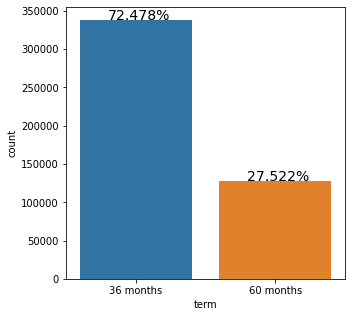

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(x=df1['term'])
plt.text(x=-0.2,y=337953,s='72.478%',fontsize=14)
plt.text(x=0.8,y=128332,s='27.522%',fontsize=14)
plt.show()

Feature `term` didominasi oleh label '36 month' dengan persentase 72.478% dari total populasi. 

### **Feature grade dan sub_grade**

In [ ]:
grade = df1.groupby('grade').agg({'id':'count'}).reset_index()
grade.columns=['grade','total']
grade['%'] = round(grade.total*100/sum(grade.total),3)
grade

,grade,total,%
0,A,74867,16.056
1,B,136929,29.366
2,C,125293,26.870
3,D,76888,16.489
4,E,35757,7.668
5,F,13229,2.837
6,G,3322,0.712


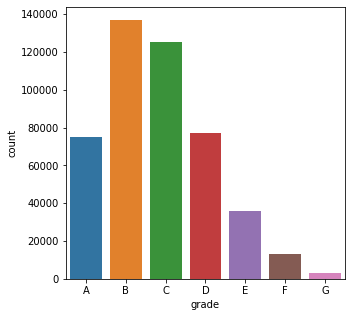

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(x=df1['grade'])
plt.show()

Feature `grade` didominasi oleh label 'B' dan 'C' yang masing-masing memiliki persentase 29.366% dan 26.870% dari jumlah total populasi

In [ ]:
sub_grade = df1.groupby('sub_grade').agg({'id':'count'}).reset_index()
sub_grade.columns=['sub_grade','total']
sub_grade['%'] = round(sub_grade.total*100/sum(sub_grade.total),3)
sub_grade

,sub_grade,total,%
0,A1,10541,2.261
1,A2,10956,2.350
2,A3,12568,2.695
3,A4,19045,4.084
4,A5,21757,4.666
5,B1,22876,4.906
6,B2,26610,5.707
7,B3,31686,6.795
8,B4,30505,6.542
9,B5,25252,5.416


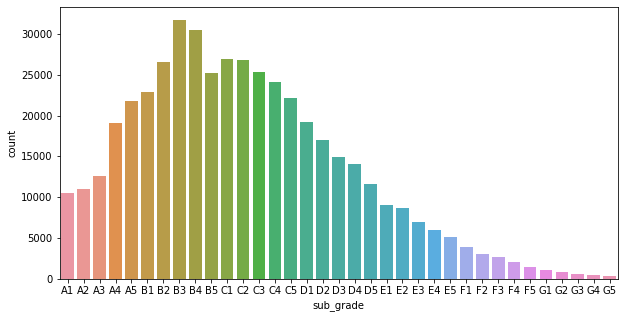

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x=df1['sub_grade'])
plt.show()

Pada feature `sub_grade` didominasi oleh label 'B2' dan 'B3' dengan persentase masing-masing sebesar 5.707% dan 6.795% dari jumlah total populasi 

### **Feature emp_length**

In [ ]:
emp_length = df1.groupby('emp_length').agg({'id':'count'}).reset_index()
emp_length.columns=['emp_length','total']
emp_length['%'] = round(emp_length.total*100/sum(emp_length.total),3)
emp_length

,emp_length,total,%
0,< 1 year,36265,8.144
1,1 year,29622,6.652
2,2 years,41373,9.292
3,3 years,36596,8.219
4,4 years,28023,6.293
5,5 years,30774,6.911
6,6 years,26112,5.864
7,7 years,26180,5.879
8,8 years,22395,5.029
9,9 years,17888,4.017


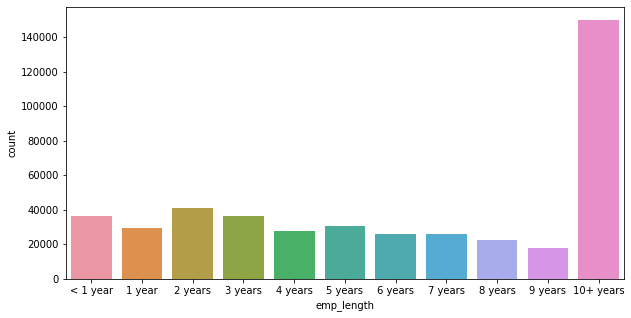

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x=df1['emp_length'])
plt.show()

Feature `emp_length` didominasi dengan label '10+ years' dengan persentase sebesar 33.698% dari jumlah total populasi

### **Feature home_ownership**

In [ ]:
home_ownership = df1.groupby('home_ownership').agg({'id':'count'}).reset_index()
home_ownership.columns=['home_ownership','total']
home_ownership['%'] = round(home_ownership.total*100/sum(home_ownership.total),3)
home_ownership=home_ownership.sort_values('%',ascending=False)
home_ownership

,home_ownership,total,%
1,MORTGAGE,235875,50.586
5,RENT,188473,40.420
4,OWN,41704,8.944
3,OTHER,182,0.039
2,NONE,50,0.011
0,ANY,1,0.000


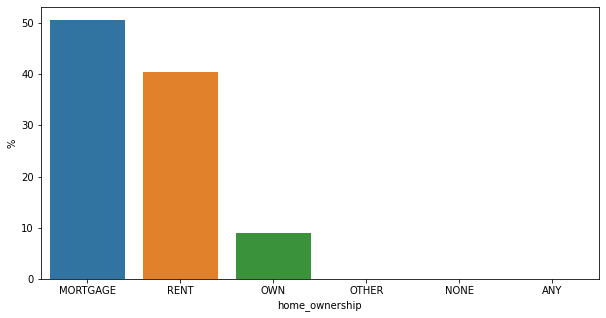

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=home_ownership['home_ownership'],y=home_ownership['%'])
plt.show()

Feature home_ownership didominasi oleh label MORTGAGE dengan persentase 50.586% dari jumlah total populasi. Label NONE dan ANY dapat digabungkan dengan label OTHER

### **Feature pymnt_plan**

In [ ]:
pymnt_plan = df1.groupby('pymnt_plan').agg({'id':'count'}).reset_index()
pymnt_plan.columns=['pymnt_plan','total']
pymnt_plan['%'] = round(pymnt_plan.total*100/sum(pymnt_plan.total),3)
pymnt_plan=pymnt_plan.sort_values('%',ascending=False)
pymnt_plan

,pymnt_plan,total,%
0,n,466276,99.998
1,y,9,0.002


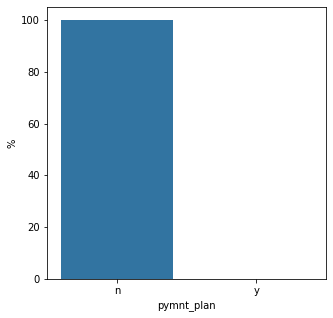

In [ ]:
plt.figure(figsize=(5,5))
sns.barplot(x=pymnt_plan['pymnt_plan'],y=pymnt_plan['%'])
plt.show()

Feature `pymnt_plan` didominasi oleh label n dengan persentase sebesar 99.998% dari jumlah total populasi. Imbalance ekstreme

### **Feature Purpose**

In [ ]:
purpose = df1.groupby('purpose').agg({'id':'count'}).reset_index()
purpose.columns=['purpose','total']
purpose['%'] = round(purpose.total*100/sum(purpose.total),3)
purpose=purpose.sort_values('%',ascending=False)
purpose

,purpose,total,%
2,debt_consolidation,274195,58.804
1,credit_card,104157,22.338
4,home_improvement,26537,5.691
9,other,23690,5.081
6,major_purchase,9828,2.108
11,small_business,7013,1.504
0,car,5397,1.157
7,medical,4602,0.987
8,moving,2994,0.642
12,vacation,2487,0.533


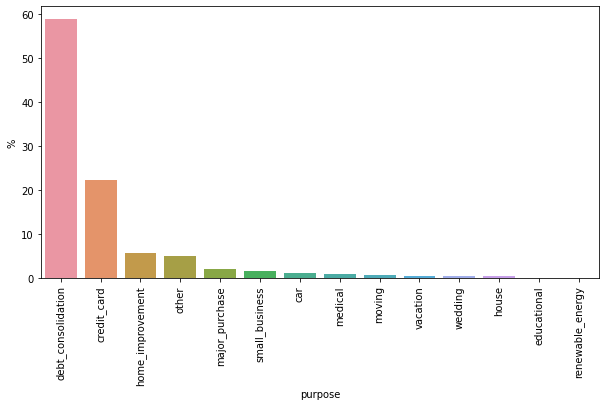

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=purpose['purpose'],y=purpose['%'])
plt.xticks(rotation=90)
plt.show()

Feature `purpose` didominasi label debt_consolidation dengan persentase 58.804% dari jumlah total populasi

### **Feature initial_list_status**

In [ ]:
initial_list_status = df1.groupby('initial_list_status').agg({'id':'count'}).reset_index()
initial_list_status.columns=['initial_list_status','total']
initial_list_status['%'] = round(initial_list_status.total*100/sum(initial_list_status.total),3)
initial_list_status=initial_list_status.sort_values('%',ascending=False)
initial_list_status

,initial_list_status,total,%
0,f,303005,64.983
1,w,163280,35.017


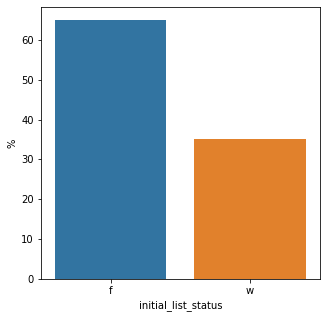

In [ ]:
plt.figure(figsize=(5,5))
sns.barplot(x=initial_list_status['initial_list_status'],y=initial_list_status['%'])
plt.show()

Feature `initial_list_status` didominasi oleh label f dengan presentase sebesar 64.983% dari jumlah total populasi

**Observasi:**
* Feature `term` didominasi oleh label 36 months
* Feature `grade` didominasi oleh label B dan C
* Feature `sub_grade`didominasi oleh sub dari label B dan C
* Feature `emp_length` didominasi oleh user yang bekerja 10 tahun ke atas
* Feature `home_ownership` didominasi oleh label MORTGAGE. Label NONE dan ANY dapat digabungkan dengan label OTHER
* Feature `verification_status` label Verified paling tinggi
* Feature `pymnt_plan` didominasi label n (imbalance ekstrem)
* Feature `purpose` didominasi label debt_consolidation
* Feature `initial_list_status` didominasi label f

### **Feature Engineering : Date**

In [ ]:
print(to_date)

['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']


In [ ]:
df1[to_date].head()

,issue_d,earliest_cr_line,last_pymnt_d,next_pymnt_d,last_credit_pull_d
0,Dec-11,Jan-85,Jan-15,NaN,Jan-16
1,Dec-11,Apr-99,Apr-13,NaN,Sep-13
2,Dec-11,Nov-01,Jun-14,NaN,Jan-16
3,Dec-11,Feb-96,Jan-15,NaN,Jan-15
4,Dec-11,Jan-96,Jan-16,Feb-16,Jan-16


Memisahkan feature month dan year

In [ ]:
df1['issue_d_month'] = df1.issue_d.str[:3]
df1['issue_d_year'] = np.where(df1.issue_d.str[4:].astype('float64')>30,'19'+ df1.issue_d.str[4:],'20'+ df1.issue_d.str[4:])

df1['earliest_cr_line_month'] = df1.earliest_cr_line.str[:3]
df1['earliest_cr_line_year'] = np.where(df1.earliest_cr_line.str[4:].astype('float64')>30,'19'+ df1.earliest_cr_line.str[4:],'20'+ df1.earliest_cr_line.str[4:])

df1['last_pymnt_d_month'] = df1.last_pymnt_d.str[:3]
df1['last_pymnt_d_year'] = np.where(df1.last_pymnt_d.str[4:].astype('float64')>30,'19'+ df1.last_pymnt_d.str[4:],'20'+ df1.last_pymnt_d.str[4:])

df1['next_pymnt_d_month'] = df1.next_pymnt_d.str[:3]
df1['next_pymnt_d_year'] = np.where(df1.next_pymnt_d.str[4:].astype('float64')>30,'19'+ df1.next_pymnt_d.str[4:],'20'+ df1.next_pymnt_d.str[4:])

df1['last_credit_pull_d_month'] = df1.last_credit_pull_d.str[:3]
df1['last_credit_pull_d_year'] = np.where(df1.last_credit_pull_d.str[4:].astype('float64')>30,'19'+ df1.last_credit_pull_d.str[4:],'20'+ df1.last_credit_pull_d.str[4:])

In [ ]:
df1[['issue_d_month','issue_d_year', 'earliest_cr_line_month', 'earliest_cr_line_year',
     'last_pymnt_d_month', 'last_pymnt_d_year', 'next_pymnt_d_month','next_pymnt_d_year', 
     'last_credit_pull_d_month','last_credit_pull_d_year']].head()

,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,next_pymnt_d_month,next_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year
0,Dec,2011,Jan,1985,Jan,2015,NaN,NaN,Jan,2016
1,Dec,2011,Apr,1999,Apr,2013,NaN,NaN,Sep,2013
2,Dec,2011,Nov,2001,Jun,2014,NaN,NaN,Jan,2016
3,Dec,2011,Feb,1996,Jan,2015,NaN,NaN,Jan,2015
4,Dec,2011,Jan,1996,Jan,2016,Feb,2016,Jan,2016


In [ ]:
df1[['issue_d','issue_d_month','issue_d_year',
     'earliest_cr_line','earliest_cr_line_month','earliest_cr_line_year',
     'last_pymnt_d','last_pymnt_d_month','last_pymnt_d_year',
     'next_pymnt_d','next_pymnt_d_month','next_pymnt_d_year',
     ]].isnull().sum()

issue_d                        0
issue_d_month                  0
issue_d_year                   0
earliest_cr_line              29
earliest_cr_line_month        29
earliest_cr_line_year         29
last_pymnt_d                 376
last_pymnt_d_month           376
last_pymnt_d_year            376
next_pymnt_d              227214
next_pymnt_d_month        227214
next_pymnt_d_year         227214
dtype: int64

In [ ]:
#drop kolom yang ada pada list to_date
#df1.drop(columns=to_date,inplace=True)

In [ ]:
#membuat urutan pada feature emy_length
temp = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
month = ['issue_d_month', 'earliest_cr_line_month','last_pymnt_d_month','next_pymnt_d_month','last_credit_pull_d_month']
for i in month:
  df1[i] = pd.Categorical(df1[i], categories=temp, ordered=True)

**Feature issue_d_year**

In [ ]:
 a = df1.groupby(['issue_d_year']).agg({'id':'count'}).rename(columns={'id':'total'}).reset_index()
 a['%'] = round(a['total']*100/sum(a['total']),3)
 a

,issue_d_year,total,%
0,2007,603,0.129
1,2008,2393,0.513
2,2009,5281,1.133
3,2010,12537,2.689
4,2011,21721,4.658
5,2012,53367,11.445
6,2013,134755,28.900
7,2014,235628,50.533


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


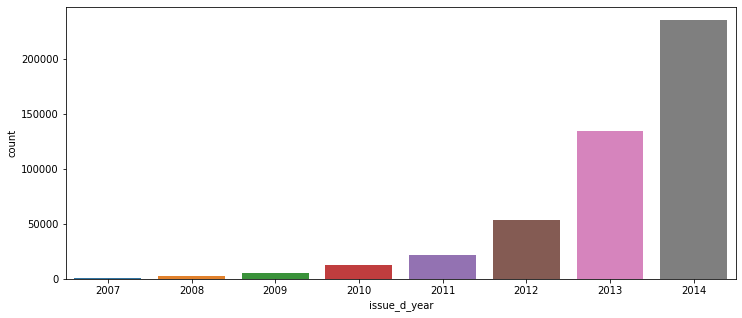

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(df1['issue_d_year'].sort_values())
plt.show()

Pada feature `issue_d_year` 50.533% dari jumlah total populasi didominasi oleh label '2014'.

**Feature earliest_cr_line_year**

In [ ]:
b = df1.groupby(['earliest_cr_line_year']).agg({'id':'count'}).rename(columns={'id':'total'}).reset_index()
b['%'] = round(b['total']*100/sum(b['total']),3)
b

,earliest_cr_line_year,total,%
0,1944,1,0.000
1,1946,2,0.000
2,1948,1,0.000
3,1949,1,0.000
4,1950,4,0.001
...,...,...,...
60,2007,12282,2.634
61,2008,7177,1.539
62,2009,3665,0.786
63,2010,2734,0.586


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


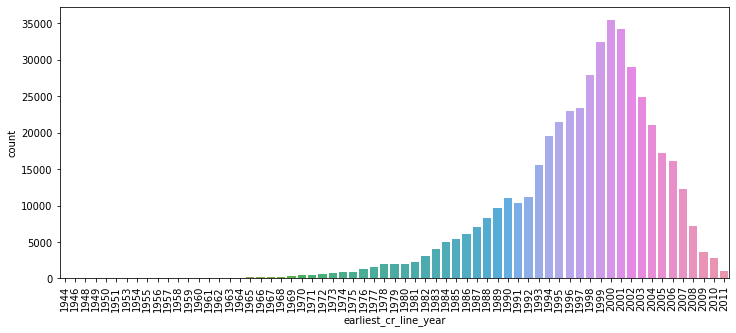

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(df1['earliest_cr_line_year'].sort_values())
plt.xticks(rotation=90)
plt.show()

Feature `earlies_cr_line_year` distribusi datanya negatively skewed

**Feature last_pymnt_d_year**

In [ ]:
c = df1.groupby(['last_pymnt_d_year']).agg({'id':'count'}).rename(columns={'id':'total'}).reset_index()
c['%'] = round(c['total']*100/sum(c['total']),3)
c

,last_pymnt_d_year,total,%
0,2007,2,0.000
1,2008,335,0.072
2,2009,838,0.180
3,2010,2420,0.519
4,2011,5748,1.234
5,2012,11813,2.535
6,2013,27194,5.837
7,2014,66595,14.294
8,2015,171344,36.776
9,2016,179620,38.553


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


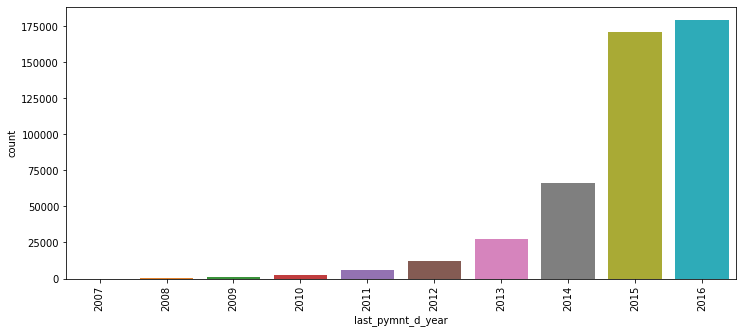

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(df1['last_pymnt_d_year'].sort_values())
plt.xticks(rotation=90)
plt.show()

Pada feature `last_pymnt_d_year` 38.553% dari jumlah total populasi didominasi oleh label tahun 2016

**Feature next_pymnt_d_year**

In [ ]:
d = df1.groupby(['next_pymnt_d_year']).agg({'id':'count'}).rename(columns={'id':'total'}).reset_index()
d['%'] = round(d['total']*100/sum(d['total']),3)
d

,next_pymnt_d_year,total,%
0,2007,1,0.000
1,2008,105,0.044
2,2009,312,0.131
3,2010,515,0.215
4,2011,820,0.343
5,2012,472,0.197
6,2013,372,0.156
7,2014,63,0.026
8,2015,79,0.033
9,2016,236332,98.854


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


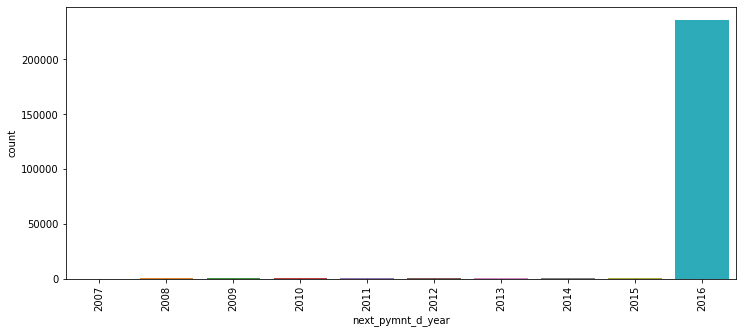

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(df1['next_pymnt_d_year'].sort_values())
plt.xticks(rotation=90)
plt.show()

Feature `next_payment_d_year` 98.854% dari jumlah total populasi didominasi oleh label tahun 2016

**Feature last_credit_pull_d_year**

In [ ]:
d = df1.groupby(['last_credit_pull_d_year']).agg({'id':'count'}).rename(columns={'id':'total'}).reset_index()
d['%'] = round(d['total']*100/sum(d['total']),3)
d

,last_credit_pull_d_year,total,%
0,2007,58,0.012
1,2008,62,0.013
2,2009,394,0.085
3,2010,1151,0.247
4,2011,2691,0.577
5,2012,5313,1.140
6,2013,12448,2.670
7,2014,31403,6.735
8,2015,85024,18.236
9,2016,327699,70.285


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


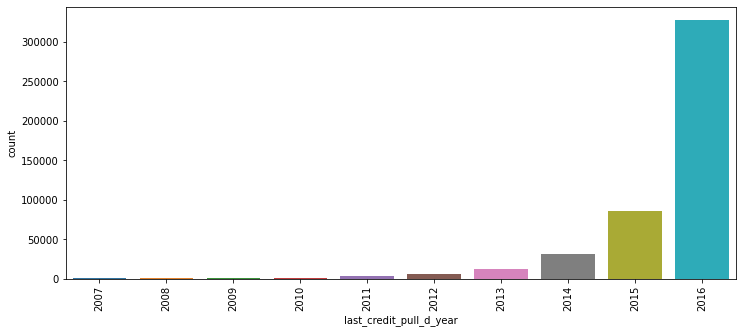

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(df1['last_credit_pull_d_year'].sort_values())
plt.xticks(rotation=90)
plt.show()

Feature `last_credit_pull_d_year` 70.285% dari jumlah total populasi didominasi oleh label tahun 2016



## Univariate Analysis : Numerical Features

In [ ]:
print(nums1)

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'target']


In [ ]:
len(nums1)

35

In [ ]:
temp = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 
        'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 
        'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 
        'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
        'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
        'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 
        'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 
        'total_rev_hi_lim']

In [ ]:
len(temp)

32

### Distribution Numerical Features

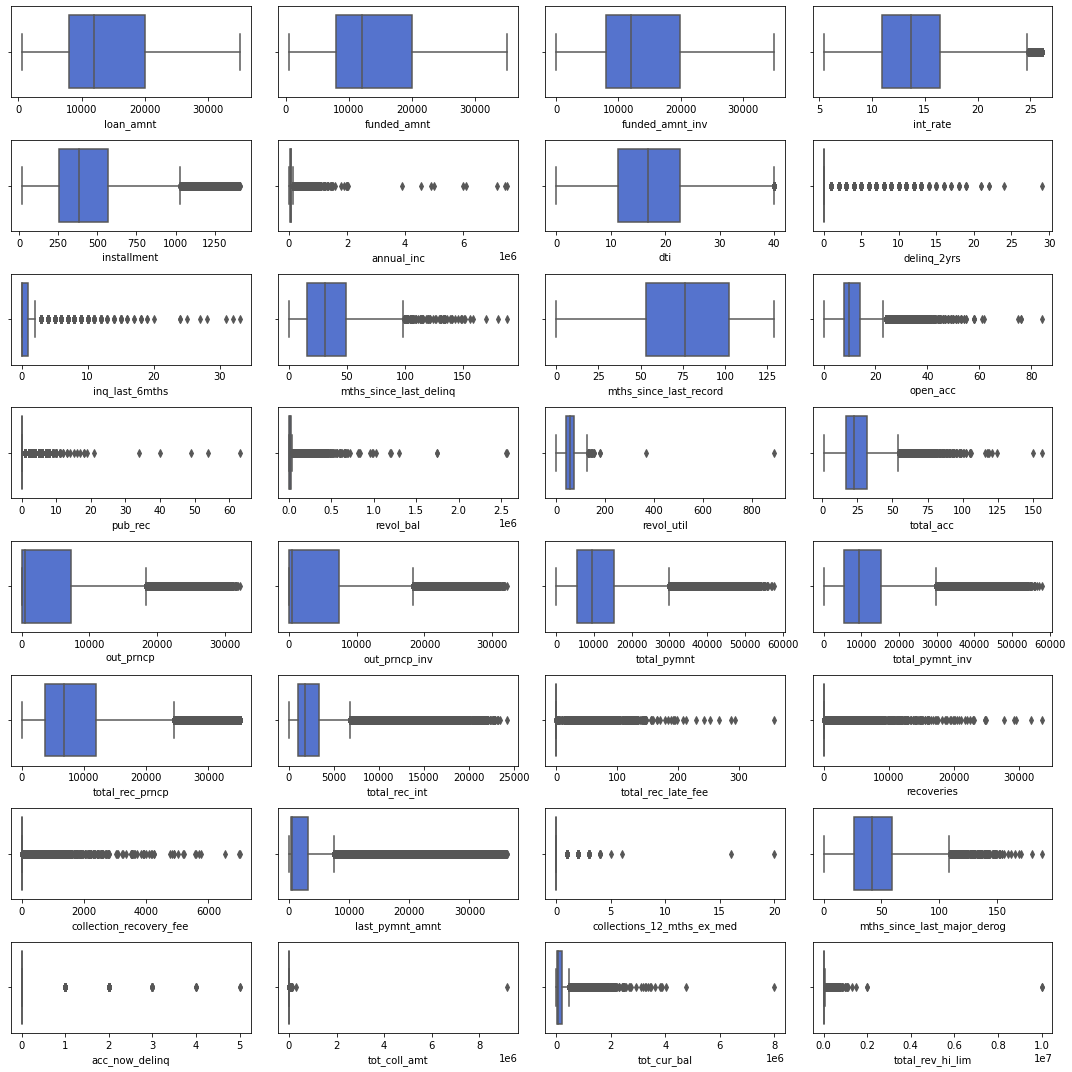

In [ ]:
plt.figure(figsize=(15,15))
for i in range(0, len(temp)):
    plt.subplot(8, 4, i+1)
    sns.boxplot(x=df1[temp[i]], color='royalblue')
    plt.xlabel(temp[i])
    plt.tight_layout()

In [ ]:
df1[temp].columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'],
      dtype='object')

**Observasi:**
* Feature yang tidak memiliki outliers `'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'dti', 'mths_since_last_record'`
* Feature `acc_now_delinq` merupakan data ordinal

## Bivariate Analysis : Categorical Features

In [ ]:
print(cats1)

['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'initial_list_status']


In [ ]:
temp = ['term', 'grade','emp_length', 'home_ownership', 'verification_status',
        'pymnt_plan', 'purpose', 'initial_list_status']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

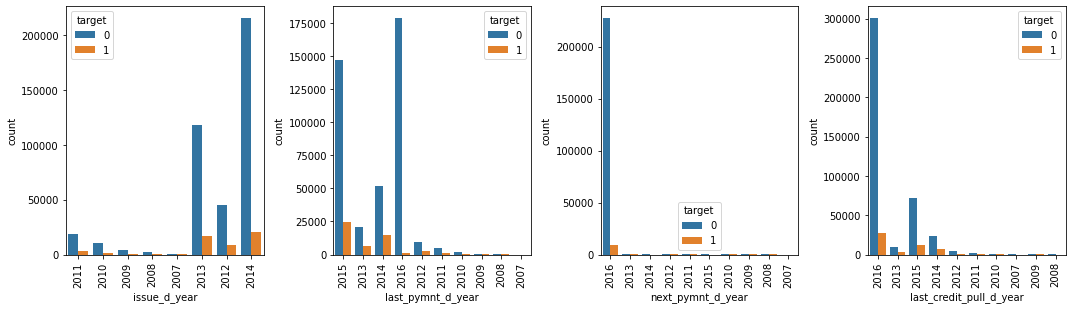

In [ ]:
plt.figure(figsize=(15,8))
for i in range(0, len(temp)):
    plt.subplot(2, 4, i+1)
    sns.countplot(df1[temp[i]], hue=df1['target'])
    plt.xlabel(temp[i])
    plt.xticks(rotation=90)
    plt.tight_layout()

**Observasi:**
* Pada feature `term` jumlah tertinggi dari peminjam yang aggal abayr ada pada kategori `term = 36 months`.
* jumlah peminjam yang gagal bayar terbanyak pada feature `grade` adalah pelanggan dengan `grade = C`
* jumlah peminjam yang gagal bayar terbanyak pada feature `emp_length` adalah pelanggan dengan masa kerja lebih dari 10 tahun. Sedangkan untuk pelanggan dengan masa kerja kurang dari 10 tahun, jumlah peminjam yang gagal bayar rerata cukup sama jumlahnya.
* Berdasarkan `home_ownership` jumlah peminjam yang gagal bayar terbanyak adalah pelanggan dengan tipe `home_ownership` 'RENT' dan 'MORTGAGE'.
* Berdasarkan `verification_status` jumlah peminjam yang gagal bayar paling banyak pada satatus 'Verified'. Sedangkan untuk status yang lain, peminjam yang gagal bayar memiliki rata-rata jumlah yang sama.
* Berdasarkan feature `purpose` jumlah peminjam yang gagal bayar paling banyak ada pada tujuan peminjaman untuk 'debt_consolidation'.
* Berdasarkan feature `initial_list_status` jumlah peminjam yang gagal bayar paling banyak adalh kategori 'f'.

In [ ]:
temp = ['issue_d_year','last_pymnt_d_year','next_pymnt_d_year','last_credit_pull_d_year'] #'earliest_cr_line_year'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

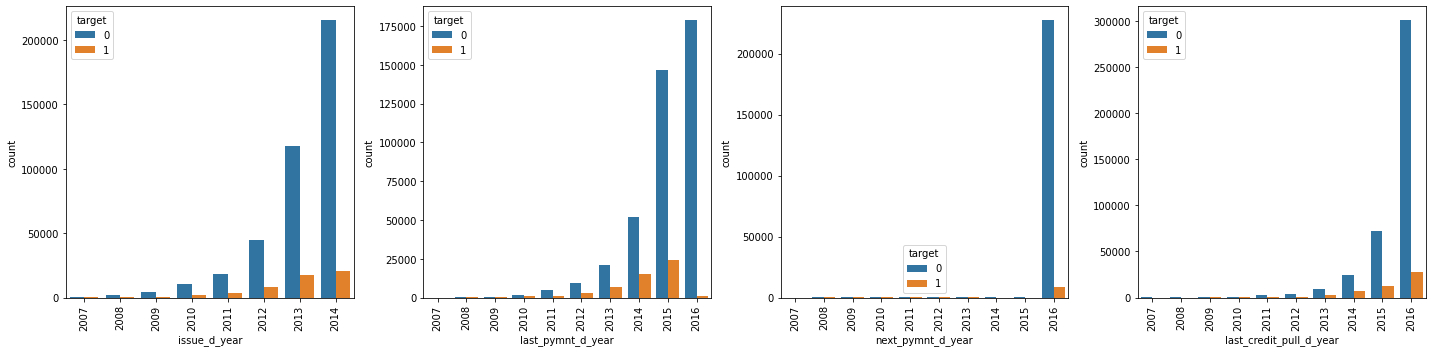

In [ ]:
plt.figure(figsize=(20,5))
for i in range(0, len(temp)):
    plt.subplot(1, 4, i+1)
    sns.countplot(df1[temp[i]].sort_values(), hue=df1['target'])
    plt.xlabel(temp[i])
    plt.xticks(rotation=90)
    plt.tight_layout()

**Observasi:**
* Pada feature `issue_d_year` jumlah peminjam yang mampu dan gagal bayar meningkat setiap tahunnya. Jumlah total peminjam yang gagal bayar paling tinggi ada pada tahun 2014.
* Pada feature `last_pymnt_d_year` jumlah peminjam yang mampu dan gagal bayar meningkat setiap tahunnya. Akan tetapi, pada tahun 2016, Jumlah peminjam yang gagal bayar jumlahnya menurun.
* Pada feature `next_pymnt_d_year` jumlah peminjam yang gagal bayar tertinggi ada pada tahun 2016
* Pada feature `last_credit_pull_d_year` jumlah peminjam yang mampu dan gagal bayar setiap tahunnya meningkat. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


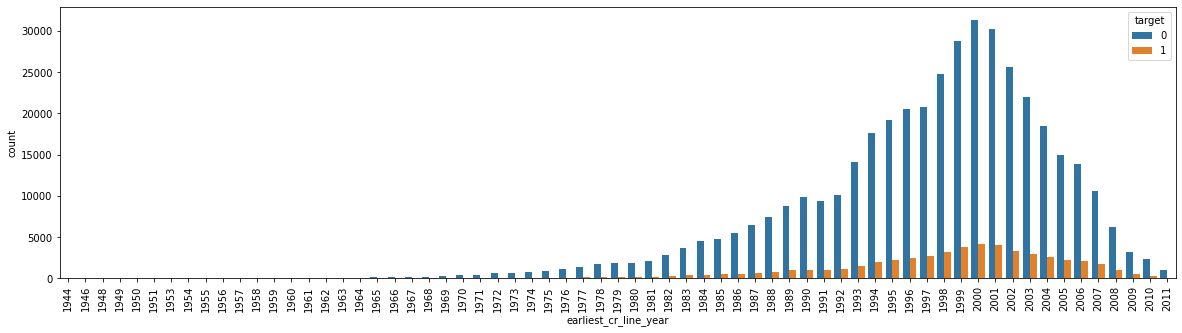

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot(df1['earliest_cr_line_year'].sort_values(), hue=df1['target'])
plt.xticks(rotation=90)
plt.show()

Pada feature `earliest_cr_line_year` jumlah peminjam yag mampu bayar berbading lurus dengan yang gagal bayar. Jika jumlah peminjam yang mampu bayar meningkat maka jumlah yang gagal bayar pun akan meningkat.

## Bivariate Analysis : Numerical Features

In [ ]:
print(nums1)

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'target']


In [ ]:
temp = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']

In [ ]:
print(temp)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']


In [ ]:
len(temp)

32

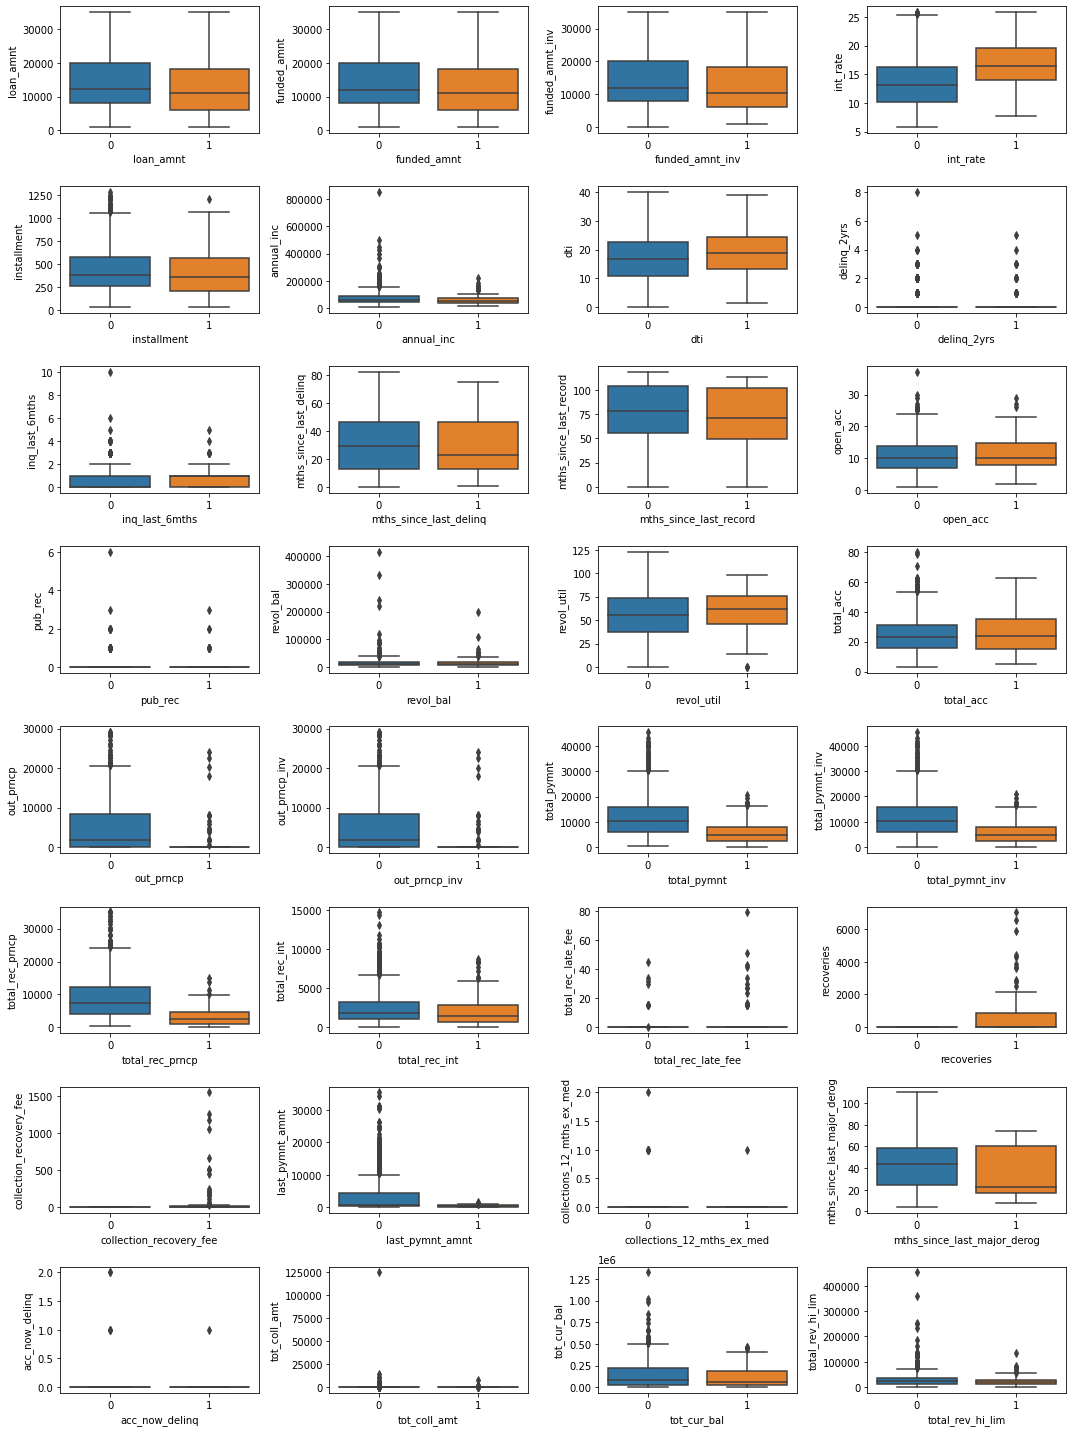

In [ ]:
df_sample=df1.sample(1000,random_state=1)
plt.figure(figsize=(15,20))
for i in range(0, len(temp)):
    plt.subplot(8, 4, i+1)
    sns.boxplot(y=df_sample[temp[i]], x=df1['target'])
    plt.xlabel(temp[i])
    plt.tight_layout()

**Observasi:**
* Peminjam dengan nilai `total_rec_prncp` diantara 0 hingga 5000 adalah peminjam yang gagal bayar. Sedangkan peminjam dengan nilai `total_rec_prncp` lebih dari 5000 adlaah peminjam yang mampu bayar
* Pada feature `total_rec_int` peminjam yang mampu dan gagal bayar ada pada rentang yang sama, yaitu antara 0 hingga 5000. 
* Peminjam yang gagal bayar memiliki nilai `total_rec_late_fee`yang lebih tinggi dibandingkan peminjam yang mampu bayar
* Peminjam dengan nilai `recoveries`> 0 merupakan peminjam yang gagal bayar. Sedangkan peminjam dengan `recoveries` = 0 merupakan peminjam yang mampu bayar.
* Peminjam dengan `collection_recovery_fee` > 0 adalah peminjam yang gagal bayar. Sedangkan, peminjam dengan `collection_recovery_fee` = 0 adalah peminjam yang dapat bayar.
* Pada feature `last_pymnt_amnt` peminjam yang total pembayaran terakhir (`last_pymnt_amnt`) < 10000 adalah peminjam yang gagal bayar.
* Peminjam dengan nilai `mnth_since_Last_major_derog` diantara 0 hingga 75 adalah peminjam yang gagal bayar.
* Peminjam dengan nilai `tot_cur_bal` diantara 0 hingga 0.5 adalah peminjam yang gagal bayar. 
* Peminjam dengan nilai `total_rev_hi_lim` diantara 0 hingga 150000 adalah peminjam yang gagal bayar.

## Multivariate Analysis

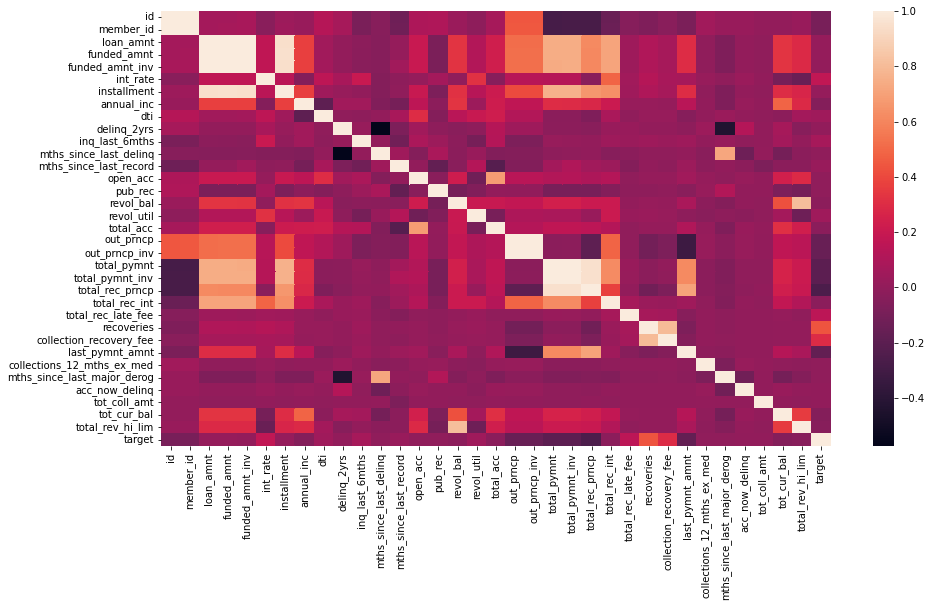

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(df1.corr(),fmt='2.f')
plt.show()

## Insight

Menghitung sisa pinjaman pokok dari tiap peminjam

In [ ]:
df1[df1['target']==1].head(1)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,car,1.0,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.71,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,0.0,NaN,NaN,NaN,1


In [ ]:
a = df1[df1['target']==1][['loan_amnt','funded_amnt','term','int_rate','installment',
                       'out_prncp','out_prncp_inv','total_pymnt',
                       'total_pymnt_inv','total_rec_prncp','total_rec_int',
                       'total_rec_late_fee','recoveries','collection_recovery_fee']]
a['must_payment'] = np.where(a['term']=='60 months',a['installment']*60,a['installment']*36)
a.head(3)

,loan_amnt,funded_amnt,term,int_rate,installment,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,must_payment
1,2500,2500,60 months,15.27,59.83,0.0,0.0,1008.71,1008.71,456.46,435.17,0.0,117.08,1.11,2153.88
8,5600,5600,60 months,21.28,152.39,0.0,0.0,646.02,646.02,162.02,294.94,0.0,189.06,2.09,5486.04
9,5375,5375,60 months,12.69,121.45,0.0,0.0,1476.19,1469.34,673.48,533.42,0.0,269.29,2.52,4372.20


In [ ]:
#sisa yang harus dibayar oleh peminjam
a['dif'] = a['must_payment'] - (a['total_pymnt']+a['total_rec_late_fee']+a['collection_recovery_fee'])
a.head(3)

,loan_amnt,funded_amnt,term,int_rate,installment,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,must_payment,dif
1,2500,2500,60 months,15.27,59.83,0.0,0.0,1008.71,1008.71,456.46,435.17,0.0,117.08,1.11,2153.88,1144.06
8,5600,5600,60 months,21.28,152.39,0.0,0.0,646.02,646.02,162.02,294.94,0.0,189.06,2.09,5486.04,4837.93
9,5375,5375,60 months,12.69,121.45,0.0,0.0,1476.19,1469.34,673.48,533.42,0.0,269.29,2.52,4372.20,2893.49


* `out_prncp`: Sisa pokok pinjaman untuk jumlah total yang didanai
* `out_prncp_inv`: Sisa pokok pinjaman untuk sebagian dari jumlah total yang didanai oleh investor
* `total_pymt`: Pembayaran diterima hingga saat ini untuk jumlah total yang didanai
* `total_rec_prncp`: Pinjaman pokok yang diterima hingga saat ini
* `total_rec_int`: Bunga yang diterima hingga saat ini


In [ ]:
round(sum(a.dif),3)

460592124.909

In [ ]:
a.shape

(52186, 16)

Feature `must_payment` merupakan jumlah yang harus dibayar oleh peminjam. Feature `dif` merupakan selisih dari `must_payment`dan `total_pymnt` yang berarti seseorang masih memiliki kewajiban membayar sebesar `dif`. Perusahaan akan berpotensi loss sebesar $460,592,124.909 karena 52186 peminjam merupakan peminjam yang buruk (tidak mampu/gagal bayar)

### total_rec_prncp

In [ ]:
ma1 = df1.groupby(['target','purpose']).agg({'total_rec_prncp':'mean'}).reset_index().sort_values(['total_rec_prncp'],ascending=False)
ma1.columns = ['target','purpose','avg_total_rec_prncp']
ma1

,target,purpose,avg_total_rec_prncp
5,0,house,11991.249117
11,0,small_business,11442.673746
2,0,debt_consolidation,9924.234277
13,0,wedding,9666.934062
1,0,credit_card,9626.360427
4,0,home_improvement,9383.971683
10,0,renewable_energy,7914.879461
6,0,major_purchase,7454.469465
9,0,other,6650.086478
3,0,educational,6382.709251


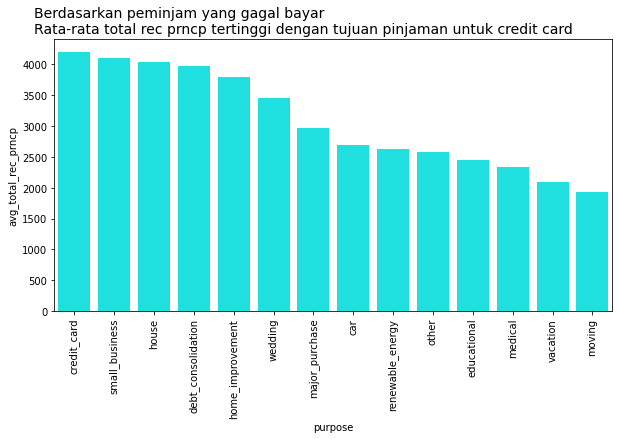

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='purpose',y=ma1['avg_total_rec_prncp'].sort_values(ascending=False),data=ma1[ma1['target']==1],color='cyan')
plt.text(x=-1,y=4500,s='Berdasarkan peminjam yang gagal bayar\nRata-rata total rec prncp tertinggi dengan tujuan pinjaman untuk credit card',fontsize=14)
plt.xticks(rotation=90)
plt.show()

Rata-rata `total_rec_prncp` peminjam yang mampu bayar lebih besar dibandingkan dengan yang gagal bayar.

In [ ]:
ma2 = df1.groupby(['target','grade']).agg({'total_rec_prncp':'mean'}).reset_index().sort_values(['total_rec_prncp'],ascending=False)
ma2.columns = ['target','grade','avg_total_rec_prncp']
ma2

,target,grade,avg_total_rec_prncp
6,0,G,12004.453080
5,0,F,10800.002808
0,0,A,10013.988682
4,0,E,9877.378355
1,0,B,9615.181232
2,0,C,9081.484847
3,0,D,8965.324084
7,1,A,4701.058751
8,1,B,4490.793155
9,1,C,3856.203401


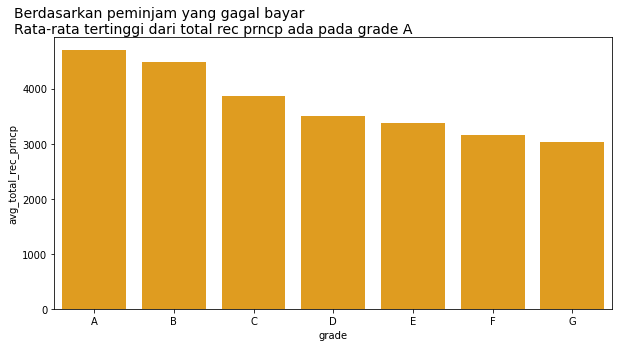

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='grade',y='avg_total_rec_prncp',data=ma2[ma2['target']==1],color='orange')
plt.text(x=-1,y=5000,s='Berdasarkan peminjam yang gagal bayar\nRata-rata tertinggi dari total rec prncp ada pada grade A',fontsize=14)
plt.show()

In [ ]:
ma3 = df1.groupby(['target','grade','purpose']).agg({'total_rec_prncp':'mean'}).reset_index()
ma3.columns = ['target','grade','purpose','avg_total_rec_prncp']
ma3[ma3['target']==1].sort_values(['avg_total_rec_prncp'],ascending=False)

,target,grade,purpose,avg_total_rec_prncp
103,1,A,house,5328.207222
102,1,A,home_improvement,5190.776949
99,1,A,credit_card,5140.611438
100,1,A,debt_consolidation,5001.268284
123,1,B,small_business,4916.038701
...,...,...,...,...
162,1,E,moving,1494.051442
190,1,G,moving,1272.463333
157,1,E,educational,1263.698667
182,1,G,car,1250.412857


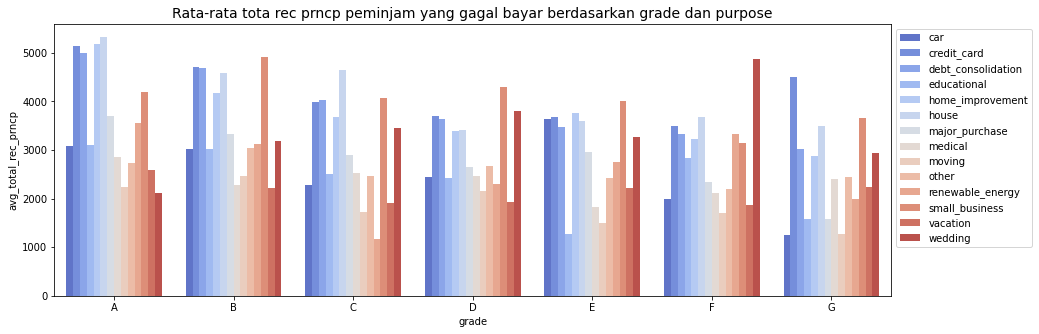

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x='grade',y='avg_total_rec_prncp',hue='purpose',data=ma3[ma3['target']==1],palette='coolwarm')
plt.title('Rata-rata tota rec prncp peminjam yang gagal bayar berdasarkan grade dan purpose',fontsize=14)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

Jika peminjam yang gagal bayar ditinjau dari `grade`,`purpose`, dan rata-rata `total_rec_prncp` maka peminjam yang ada pada kategori `grade` A dengan tujuan pinjaman untuk rumah. Di posisi kedua dan ketiga juga ada pada kategori `grade` A dengan tujuan pinjaman secara berturut-turut untuk perbaikan rumah dan kartu kredit. Sehingga dapat disimpulkan bahwa, untuk mengurangi peminjam yang gagal bayar dapat mempertimbangkan untuk menolak peminjam yang berada di `grade` A.

In [ ]:
df1.groupby('target').agg({'total_rec_prncp':'mean'})

,total_rec_prncp
target,
0,9500.691637
1,3829.815241


### collection_recovery_fee

In [ ]:
ma4 = df1.groupby(['target','purpose']).agg({'collection_recovery_fee':'mean'}).reset_index().sort_values(['collection_recovery_fee'],ascending=False)
ma4.columns = ['target','purpose','avg_collection_recovery_fee']
ma4[ma4['target']==1]

,target,purpose,avg_collection_recovery_fee
24,1,renewable_energy,146.028452
17,1,educational,132.148825
27,1,wedding,109.072855
25,1,small_business,107.501345
18,1,home_improvement,86.553666
16,1,debt_consolidation,83.727046
19,1,house,76.077878
15,1,credit_card,75.756100
20,1,major_purchase,66.479359
21,1,medical,59.418772


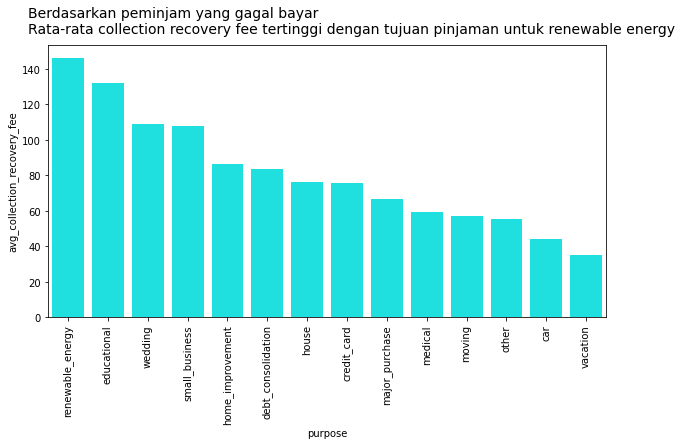

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='purpose',y=ma4['avg_collection_recovery_fee'].sort_values(ascending=False),data=ma4[ma4['target']==1],color='cyan')
plt.text(x=-1,y=160,s='Berdasarkan peminjam yang gagal bayar\nRata-rata collection recovery fee tertinggi dengan tujuan pinjaman untuk renewable energy',fontsize=14)
plt.xticks(rotation=90)
plt.show()

In [ ]:
ma5 = df1.groupby(['target','grade']).agg({'collection_recovery_fee':'mean'}).reset_index().sort_values(['collection_recovery_fee'],ascending=False)
ma5.columns = ['target','grade','avg_collection_recovery_fee']
ma5[ma5['target']==1]

,target,grade,avg_collection_recovery_fee
13,1,G,165.448684
12,1,F,139.301832
11,1,E,109.313649
10,1,D,82.809374
9,1,C,69.815587
8,1,B,55.326875
7,1,A,48.837291


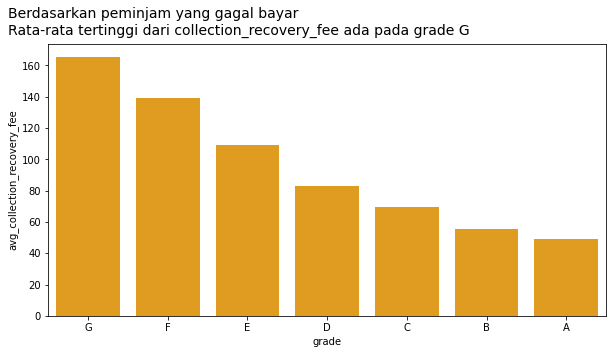

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='grade',y='avg_collection_recovery_fee',data=ma5[ma5['target']==1],color='orange')
plt.text(x=-1,y=180,s='Berdasarkan peminjam yang gagal bayar\nRata-rata tertinggi dari collection_recovery_fee ada pada grade G',fontsize=14)
plt.show()

In [ ]:
ma6 = df1.groupby(['target','grade','purpose']).agg({'collection_recovery_fee':'mean'}).reset_index()
ma6.columns = ['target','grade','purpose','avg_collection_recovery_fee']
ma6[ma6['target']==1]

,target,grade,purpose,avg_collection_recovery_fee
98,1,A,car,34.856877
99,1,A,credit_card,61.027500
100,1,A,debt_consolidation,49.153024
101,1,A,educational,139.069080
102,1,A,home_improvement,35.196451
...,...,...,...,...
191,1,G,other,119.172054
192,1,G,renewable_energy,490.346133
193,1,G,small_business,232.557967
194,1,G,vacation,179.743267


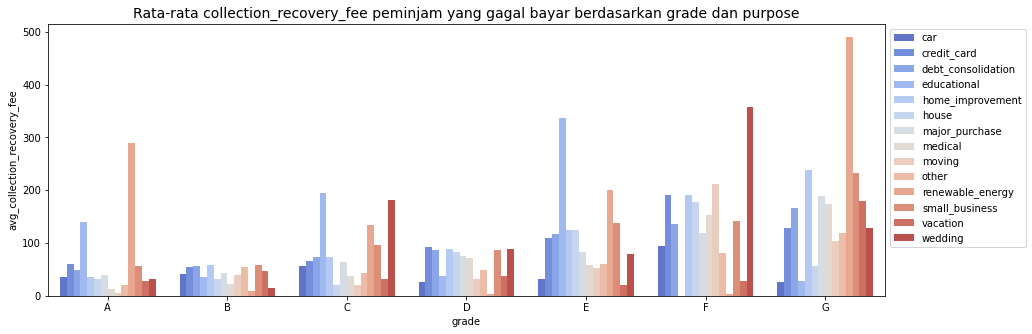

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x='grade',y='avg_collection_recovery_fee',hue='purpose',data=ma6[ma6['target']==1],palette='coolwarm')
plt.title('Rata-rata collection_recovery_fee peminjam yang gagal bayar berdasarkan grade dan purpose',fontsize=14)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

Jika peminjam yang gagal bayar ditinjau dari feature `grade`, `purpose`, dan rata-rata `collection_recovery_fee`, maka peminjam yang berisiko untuk gagal bayar tertinggi ada pada kategori `grade` G dengan tujuan peminjaman untuk energi terbarukan. Di posisi ke dua tertinggi, risiko peminjam yang gagal bayar ada pada kategori `grade` F dengan tujuan peminjaman untuk pernikahan. Di posisi ketiga tertinggi, risiko peminjam yang akakn gagal bayar ada pada kategori `grade` G dengan tujuan peminjaman untuk perbaikan rumah.  Sehingga dapat dibertimbangkan untuk peminjam yang ada pada kategori tersebut untuk ditolak peminjaman kreditnya.

### recoveries

In [ ]:
ma7 = df1.groupby(['target','purpose']).agg({'recoveries':'mean'}).reset_index().sort_values(['recoveries'],ascending=False)
ma7.columns = ['target','purpose','avg_recoveries']
ma7[ma7['target']==1]

,target,purpose,avg_recoveries
24,1,renewable_energy,1021.842593
25,1,small_business,1008.781593
19,1,house,990.171677
27,1,wedding,879.170140
18,1,home_improvement,825.340629
16,1,debt_consolidation,799.265856
15,1,credit_card,706.093851
20,1,major_purchase,672.312389
23,1,other,567.148954
21,1,medical,520.645337


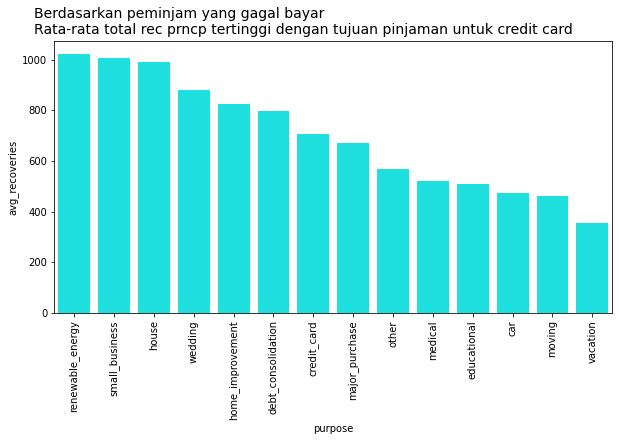

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='purpose',y=ma7['avg_recoveries'].sort_values(ascending=False),data=ma7[ma7['target']==1],color='cyan')
plt.text(x=-1,y=1100,s='Berdasarkan peminjam yang gagal bayar\nRata-rata recoveries tertinggi ada pada tujuan pinjaman untuk energi terbarukan',fontsize=14)
plt.xticks(rotation=90)
plt.show()

* Jika ditinjau berdasarkan rata-rata `recoveries` dan tujuan peminjaman (`purpose`), peminjam yang ada pada kategori `renewable_energy` memiliki rata-rata `recoveries` tertinggi yang berarti peminjam pada kategori ini cenderung akan gagal bayar (bad debt). Sehingga untuk mengurangi peminjam yang gagal bayar, dapat ditinjau kembali atau ditolak jika user melakukan pinjaman untuk tujuan `renewable_energy` karena risiko kredit akan gagal bayar.

In [ ]:
ma8 = df1.groupby(['target','grade']).agg({'recoveries':'mean'}).reset_index().sort_values(['recoveries'],ascending=False)
ma8.columns = ['target','grade','avg_recoveries']
ma8[ma8['target']==1]

,target,grade,avg_recoveries
13,1,G,1423.852622
12,1,F,1363.703600
11,1,E,1059.407706
10,1,D,771.873695
9,1,C,651.149996
8,1,B,554.666924
7,1,A,461.954499


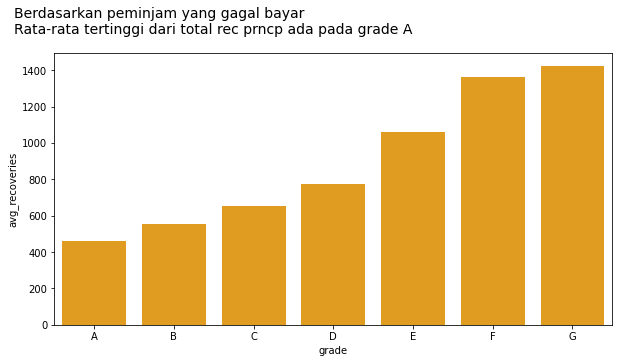

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='grade',y='avg_recoveries',data=ma8[ma8['target']==1],color='orange')
plt.text(x=-1,y=1600,s='Berdasarkan peminjam yang gagal bayar\nRata-rata tertinggi dari total rec prncp ada pada grade A',fontsize=14)
plt.show()

In [ ]:
ma9 = df1.groupby(['target','grade','purpose']).agg({'recoveries':'mean','annual_inc':'mean','dti':'mean'}).reset_index()
ma9.columns = ['target','grade','purpose','avg_recoveries','avg_annual_inc','avg_dti']
ma9[ma9['target']==1]

,target,grade,purpose,avg_recoveries,avg_annual_inc,avg_dti
98,1,A,car,298.130763,52093.377143,12.735571
99,1,A,credit_card,510.306781,70962.217863,16.799644
100,1,A,debt_consolidation,468.770374,68308.022194,16.845612
101,1,A,educational,808.816000,69809.200000,5.644000
102,1,A,home_improvement,433.655480,77425.383729,13.524124
...,...,...,...,...,...,...
191,1,G,other,1216.405242,78994.572581,17.248629
192,1,G,renewable_energy,3941.606667,96129.271667,17.611667
193,1,G,small_business,1791.611304,103633.402174,13.896304
194,1,G,vacation,1743.746667,115666.666667,16.530000


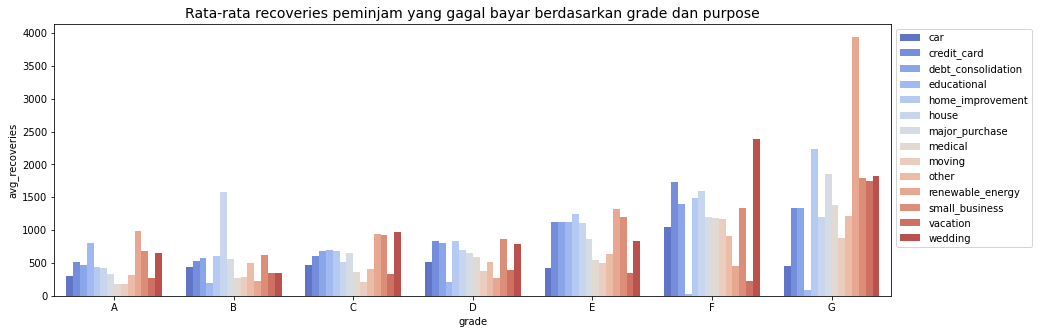

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x='grade',y='avg_recoveries',hue='purpose',data=ma9[ma9['target']==1],palette='coolwarm')
plt.title('Rata-rata recoveries peminjam yang gagal bayar berdasarkan grade dan purpose',fontsize=14)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

Jika peminjam yang gagal bayar ditinjau dari feature `grade`, `purpose`, dan rata-rata nilai `recoveries`, maka peminjam yang berada pada kategori `grade` G dengan tujuan untuk energi terbarukan perlu dipertimbangkan untuk ditolak pengajuan kreditnya karena memiliki risiko kredit gagal bayar. begitu pula dengan peminjam yang berada pada kategori `grade` F dengan tujuan peminjaman `wedding` juga perlu dipertimbangkan untuk ditolak pengajuan kreditnya karena mimiliki risiko gagal bayar. Begitu pula pada `grade` B dengan tujuan peminjaman `house` memiliki resiko kredit gagal bayar sehingga dapat dipertimbangkan untuk menolak pengajuan kreditnnya.

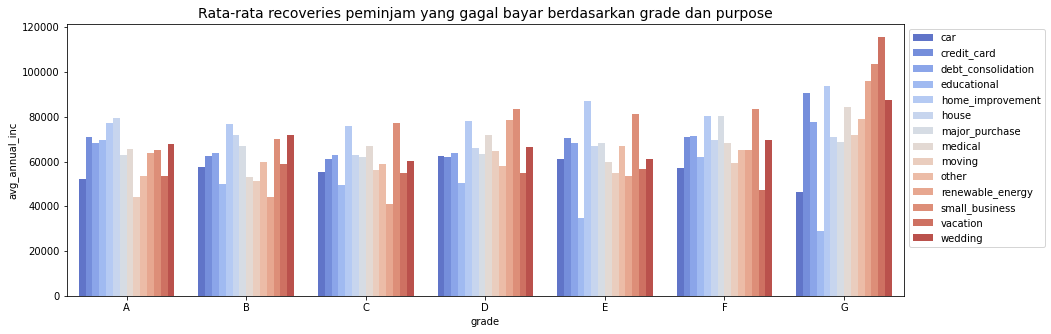

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x='grade',y='avg_annual_inc',hue='purpose',data=ma9[ma9['target']==1],palette='coolwarm')
plt.title('Rata-rata income tahunan peminjam yang gagal bayar berdasarkan grade dan purpose',fontsize=14)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [ ]:
z = df1[df1['target']==1][['grade','purpose','dti','recoveries','annual_inc']]
zg = z.groupby(['grade','purpose']).agg({'dti':'mean','recoveries':'mean'}).reset_index().sort_values(['grade','recoveries'],ascending=[True,False])
zg[zg['grade']=='G']

,grade,purpose,dti,recoveries
94,G,renewable_energy,17.611667,3941.606667
88,G,home_improvement,15.564082,2240.982449
90,G,major_purchase,21.826667,1860.398889
97,G,wedding,17.020000,1830.858571
95,G,small_business,13.896304,1791.611304
96,G,vacation,16.530000,1743.746667
91,G,medical,16.391333,1377.364000
86,G,debt_consolidation,20.204785,1338.468505
85,G,credit_card,19.789167,1336.894333
93,G,other,17.248629,1216.405242


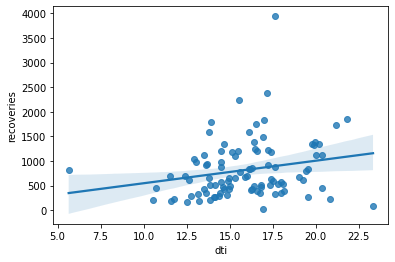

In [ ]:
sns.regplot(x='dti',y='recoveries',data=zg)

# Cleaning Data

In [ ]:
df2 = df1.copy()

In [ ]:
df2.shape

(466285, 60)

## Check Missing Values

In [ ]:
#check persentase missing values untuk setiap feature
nv = df2.isnull().sum().sort_values(ascending=False).reset_index()
nv.columns = ['feature','null']
nv['%'] = round(nv['null']*100/(df2.shape[0]),3)
nv = nv[nv['%']>0]
nv

,feature,null,%
0,mths_since_last_record,403647,86.567
1,mths_since_last_major_derog,367311,78.774
2,mths_since_last_delinq,250351,53.691
3,next_pymnt_d_year,227214,48.729
4,next_pymnt_d_month,227214,48.729
5,next_pymnt_d,227214,48.729
6,tot_coll_amt,70276,15.071
7,tot_cur_bal,70276,15.071
8,total_rev_hi_lim,70276,15.071
9,emp_length,21008,4.505


In [ ]:
#filter feature yang punya null values > 40%
nv1 = list(nv['feature'][nv['%']>40])
print(nv1)
#filter feature yang null values < 40%
nv2 = list(nv['feature'][nv['%']<40])
print(nv2)

['mths_since_last_record', 'mths_since_last_major_derog', 'mths_since_last_delinq', 'next_pymnt_d_year', 'next_pymnt_d_month', 'next_pymnt_d']
['tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'emp_length', 'last_pymnt_d', 'last_pymnt_d_month', 'last_pymnt_d_year', 'revol_util', 'collections_12_mths_ex_med', 'last_credit_pull_d', 'last_credit_pull_d_month', 'last_credit_pull_d_year', 'total_acc', 'pub_rec', 'open_acc', 'acc_now_delinq', 'inq_last_6mths', 'earliest_cr_line', 'delinq_2yrs', 'earliest_cr_line_month', 'earliest_cr_line_year', 'annual_inc']


## Handling Missing Values

Untuk feature yang memiliki null values > 40% feature tersebut dapat didrop karena tidak representatif lagi. jikalau dilakukan imputation, terlalu banyak mengubah data.<br><br>
Untuk feature yang memiliki null values < 20%, null values akan diisi nilai mendian (untuk data numerik) dan modus (untuk data kategorik) 

In [ ]:
# drop feature yang punya null values >40%
df2.drop(columns=nv1,inplace=True)

In [ ]:
temp1 = []
temp2 = []
for i in nv2:
  if (df2[i].dtype == 'object') or (df2[i].dtype =='category'):
    temp2.append(i)
  else:
    temp1.append(i)

In [ ]:
#check statistical summary from feature on list nv2
df2[temp1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tot_coll_amt,396009.0,191.913517,14630.214605,0.0,0.0,0.0,0.0,9152545.0
tot_cur_bal,396009.0,138801.713385,152114.663494,0.0,28618.0,81539.0,208953.0,8000078.0
total_rev_hi_lim,396009.0,30379.087771,37247.129571,0.0,13500.0,22800.0,37900.0,9999999.0
revol_util,465945.0,56.176947,23.732628,0.0,39.2,57.6,74.7,892.3
collections_12_mths_ex_med,466140.0,0.009085,0.108648,0.0,0.0,0.0,0.0,20.0
total_acc,466256.0,25.064430,11.600141,1.0,17.0,23.0,32.0,156.0
pub_rec,466256.0,0.160564,0.510863,0.0,0.0,0.0,0.0,63.0
open_acc,466256.0,11.187069,4.987526,0.0,8.0,10.0,14.0,84.0
acc_now_delinq,466256.0,0.004002,0.068637,0.0,0.0,0.0,0.0,5.0
inq_last_6mths,466256.0,0.804745,1.091598,0.0,0.0,0.0,1.0,33.0


Karena sebagian besar feature-feature yang memiliki nilai null distribusinya skewed maka nilai untuk mengisi nilai null adalah nilai median dari masing-masing feature.

In [ ]:
#imputation
for i in temp1:
  df2[i].fillna(df2[i].median(),inplace=True)

In [ ]:
#check null values
df2[temp1].isnull().sum()

tot_coll_amt                  0
tot_cur_bal                   0
total_rev_hi_lim              0
revol_util                    0
collections_12_mths_ex_med    0
total_acc                     0
pub_rec                       0
open_acc                      0
acc_now_delinq                0
inq_last_6mths                0
delinq_2yrs                   0
annual_inc                    0
dtype: int64

In [ ]:
df2[temp2].describe().transpose()

,count,unique,top,freq
emp_length,445277,11,10+ years,150049
last_pymnt_d,465909,98,Jan-16,179620
last_pymnt_d_month,465909,12,Jan,194421
last_pymnt_d_year,465909,10,2016,179620
last_credit_pull_d,466243,103,Jan-16,327699
last_credit_pull_d_month,466243,12,Jan,335246
last_credit_pull_d_year,466243,10,2016,327699
earliest_cr_line,466256,664,Oct-00,3674
earliest_cr_line_month,466256,12,Oct,45592
earliest_cr_line_year,466256,65,2000,35539


Untuk data bertipe kategorik, nilai null pada masing-masing feature diisi dengan nilai modus.

In [ ]:
df2['emp_length'] = df2['emp_length'].fillna('10+ years')
df2['last_pymnt_d'] = df2['last_pymnt_d'].fillna('Jan-16')
df2['last_pymnt_d_month'] = df2['last_pymnt_d_month'].fillna('Jan')
df2['last_pymnt_d_year'] = df2['last_pymnt_d_year'].fillna('2016')
df2['last_credit_pull_d'] = df2['last_credit_pull_d'].fillna('Jan-16')
df2['last_credit_pull_d_month'] = df2['last_credit_pull_d_month'].fillna('Jan')
df2['last_credit_pull_d_year'] = df2['last_credit_pull_d_year'].fillna('2016')
df2['earliest_cr_line'] = df2['earliest_cr_line'].fillna('Oct-00')
df2['earliest_cr_line_month'] = df2['earliest_cr_line_month'].fillna('Oct')
df2['earliest_cr_line_year'] = df2['earliest_cr_line_year'].fillna('2000')

In [ ]:
df2[temp2].isnull().sum()

emp_length                  0
last_pymnt_d                0
last_pymnt_d_month          0
last_pymnt_d_year           0
last_credit_pull_d          0
last_credit_pull_d_month    0
last_credit_pull_d_year     0
earliest_cr_line            0
earliest_cr_line_month      0
earliest_cr_line_year       0
dtype: int64

In [ ]:
#recheck
df2.isnull().sum().sum()

0

## Check Duplicate Data

In [ ]:
df2.duplicated().any()

False

Dataset tidak memiliki nilai yang duplikat

# Preprecessing

In [ ]:
df2.shape

(466285, 54)

## Feature Engineering : Feature Date

### String to Datetime

In [ ]:
df2[['issue_d','last_pymnt_d','last_credit_pull_d','earliest_cr_line']].head()

,issue_d,last_pymnt_d,last_credit_pull_d,earliest_cr_line
0,Dec-11,Jan-15,Jan-16,Jan-85
1,Dec-11,Apr-13,Sep-13,Apr-99
2,Dec-11,Jun-14,Jan-16,Nov-01
3,Dec-11,Jan-15,Jan-15,Feb-96
4,Dec-11,Jan-16,Jan-16,Jan-96


In [ ]:
df2[['issue_d','last_pymnt_d','last_credit_pull_d','earliest_cr_line']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   issue_d             466285 non-null  object
 1   last_pymnt_d        466285 non-null  object
 2   last_credit_pull_d  466285 non-null  object
 3   earliest_cr_line    466285 non-null  object
dtypes: object(4)
memory usage: 14.2+ MB


In [ ]:
from datetime import datetime as dt
df2['issue_d'] = pd.to_datetime(df2['issue_d'].apply(lambda x: dt.strptime(x, '%b-%y')))
df2['last_pymnt_d'] = pd.to_datetime(df2['last_pymnt_d'].apply(lambda x: dt.strptime(x, '%b-%y')))
df2['last_credit_pull_d'] = pd.to_datetime(df2['last_credit_pull_d'].apply(lambda x: dt.strptime(x, '%b-%y')))
df2['earliest_cr_line'] = pd.to_datetime(df2['earliest_cr_line'].apply(lambda x: dt.strptime(x, '%b-%y')))

In [ ]:
df2[['last_pymnt_d','last_credit_pull_d','earliest_cr_line']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   last_pymnt_d        466285 non-null  datetime64[ns]
 1   last_credit_pull_d  466285 non-null  datetime64[ns]
 2   earliest_cr_line    466285 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 10.7 MB


In [ ]:
df2[['issue_d','last_pymnt_d','last_credit_pull_d','earliest_cr_line']].head()

,issue_d,last_pymnt_d,last_credit_pull_d,earliest_cr_line
0,2011-12-01,2015-01-01,2016-01-01,1985-01-01
1,2011-12-01,2013-04-01,2013-09-01,1999-04-01
2,2011-12-01,2014-06-01,2016-01-01,2001-11-01
3,2011-12-01,2015-01-01,2015-01-01,1996-02-01
4,2011-12-01,2016-01-01,2016-01-01,1996-01-01


### New Feature

* issue_d : The month which the loan was funded
* last_pymnt_d : Last month payment was received
* last_credit_pull_d : The most recent month LC pulled credit for this loan
* earliest_cr_line : The month the borrower's earliest reported credit line was opened

In [ ]:
df2['period'] = (df2['last_credit_pull_d'].dt.year - df2['earliest_cr_line'].dt.year) * 12 + (df2['last_credit_pull_d'].dt.month - df2['earliest_cr_line'].dt.month)
df2['period'].head()

0    372
1    173
2    170
3    227
4    240
Name: period, dtype: int64

## Feature Engineering : Categorical Features

In [ ]:
nums2 = []
cats2 = []

for i in df2.columns:
  if (df2[i].dtype == 'object') or (df2[i].dtype == 'category'):
    cats2.append(i)
  else:
    nums2.append(i)

In [ ]:
print(len(cats2))
print(cats2)

18
['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'initial_list_status', 'issue_d_month', 'issue_d_year', 'earliest_cr_line_month', 'earliest_cr_line_year', 'last_pymnt_d_month', 'last_pymnt_d_year', 'last_credit_pull_d_month', 'last_credit_pull_d_year']


In [ ]:
df2.pymnt_plan.value_counts()

n    466276
y         9
Name: pymnt_plan, dtype: int64

* Karena feature `grade` dan `sub-grade` merujuk pada hal yang sama maka akan dipilih salah satu untuk proses selanjutnya. Feature yang akan digunakan adalah `grade` karena memiliki label yang lebih sedikit dibandingkan dengan`sub-grade`
* Feature `loan_status` juga akan di drop karena sudah menjadi feature `target`
* Feature `pymnt_plan` di drop karena jumlah label 'n' dan 'y' sangat imbalance. Hal ini akan berpengaruh pada modelling dimana ML akan lebih condong pada label 'n' karena label 'n' mendominasi


In [ ]:
temp = ['term', 'grade','emp_length', 'home_ownership','verification_status','purpose','initial_list_status', 
        'issue_d_month', 'issue_d_year', 
        'earliest_cr_line_month', 'earliest_cr_line_year', 
        'last_pymnt_d_month', 'last_pymnt_d_year',
        'last_credit_pull_d_month', 'last_credit_pull_d_year']

In [ ]:
len(temp)

15

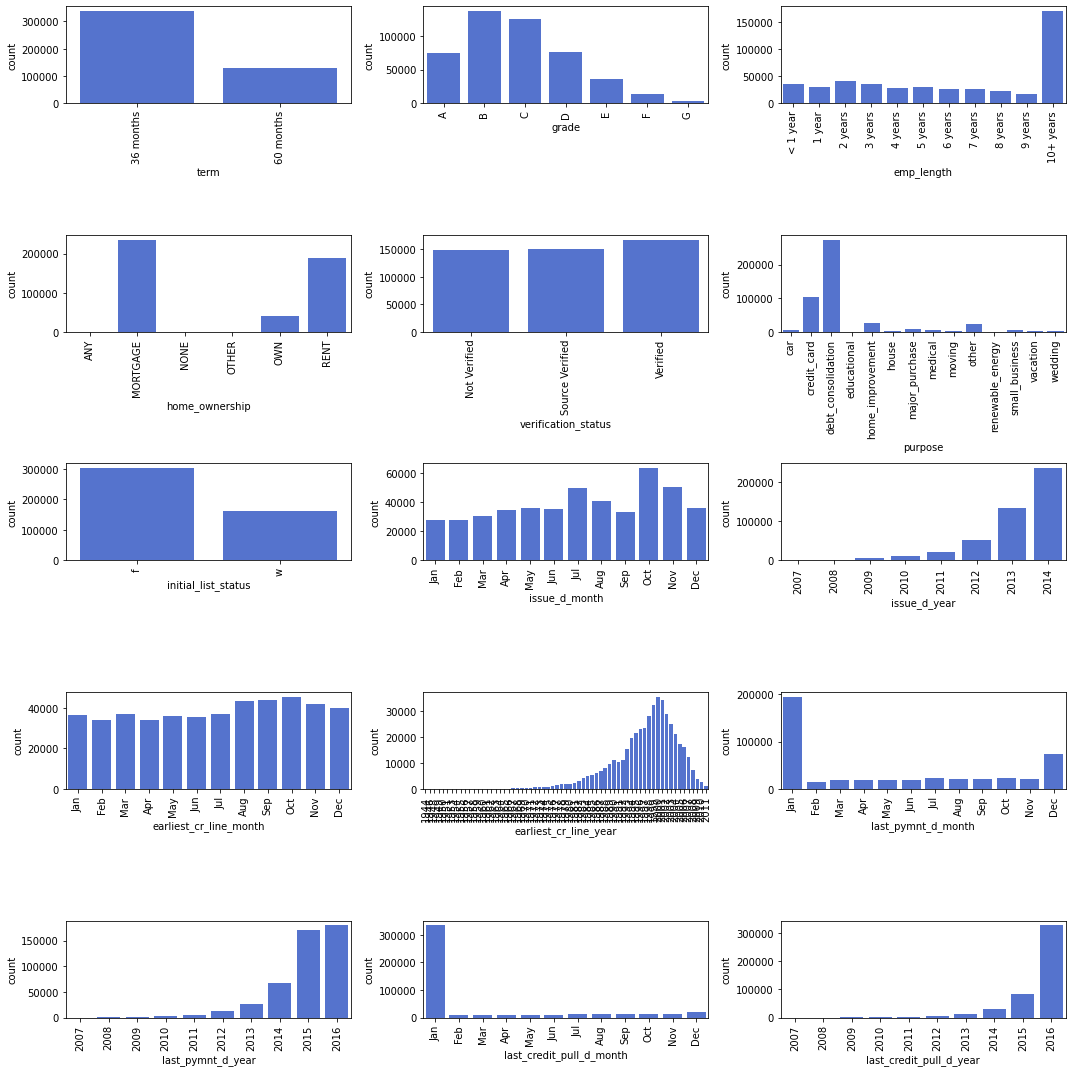

In [ ]:
plt.figure(figsize=(15,15))
for i in range(0, len(temp)):
    plt.subplot(5, 3, i+1)
    sns.countplot(x=df2[temp[i]].sort_values(), color='royalblue')
    plt.xlabel(temp[i])
    plt.xticks(rotation=90)
    plt.tight_layout()

* label 'OWN', 'NONE' dan 'ANY' pada feature `home_ownership` digabungkan dengan label 'OTHER' 

In [ ]:
df2.home_ownership.replace({'NONE':'OTHER','ANY':'OTHER','OWN':'OTHER'},inplace=True)
df2.home_ownership.unique()

array(['RENT', 'OTHER', 'MORTGAGE'], dtype=object)

* label pada feature `earliest_cr_line_year` dibuat kelompok baru agar label lebih sedikit dan jumlah masing-masing label tidak terlalu jauh

In [ ]:
def year(x):
  if int( x['earliest_cr_line_year']) >= 2000:
    result = '00s'
  else:
    if int( x['earliest_cr_line_year']) >= 1990:
      result = '90s'
    elif int( x['earliest_cr_line_year']) >= 1980:
      result = '80s'
    elif int( x['earliest_cr_line_year']) >= 1970:
      result = '70s'
    elif int( x['earliest_cr_line_year']) >= 1960:
      result = '60s'
    else:
      result = '50s'
  return result

In [ ]:
df2['earliest_cr_line_year_seg'] = df2.apply(lambda x : year(x),axis=1)
df2[['earliest_cr_line_year','earliest_cr_line_year_seg']].sample(10)

,earliest_cr_line_year,earliest_cr_line_year_seg
357354,2001,00s
66054,2001,00s
296364,1998,90s
450799,2001,00s
137795,2003,00s
293060,1988,80s
171562,1999,90s
381058,1997,90s
413597,1984,80s
178020,1992,90s


In [ ]:
df2.drop(columns='earliest_cr_line_year',inplace=True)

In [ ]:
print(temp)

['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'issue_d_month', 'issue_d_year', 'earliest_cr_line_month', 'earliest_cr_line_year', 'last_pymnt_d_month', 'last_pymnt_d_year', 'last_credit_pull_d_month', 'last_credit_pull_d_year']


In [ ]:
temp1 = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status','earliest_cr_line_year_seg']

## Feature Selection

In [ ]:
df2[nums2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   id                          466285 non-null  int64         
 1   member_id                   466285 non-null  int64         
 2   loan_amnt                   466285 non-null  int64         
 3   funded_amnt                 466285 non-null  int64         
 4   funded_amnt_inv             466285 non-null  float64       
 5   int_rate                    466285 non-null  float64       
 6   installment                 466285 non-null  float64       
 7   annual_inc                  466285 non-null  float64       
 8   issue_d                     466285 non-null  datetime64[ns]
 9   dti                         466285 non-null  float64       
 10  delinq_2yrs                 466285 non-null  float64       
 11  earliest_cr_line            466285 non-

In [ ]:
date = []
temp2 = []
for i in nums2:
  if (df2[i].dtype == 'datetime64[ns]'):
    date.append(i)
  elif (i == 'id') or (i =='member_id'):
    continue
  else:
    temp2.append(i)
print(temp2)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'target', 'period']


## Feature Encoding

In [ ]:
print(len(temp1))

8


In [ ]:
df_encode = df2.copy()

In [ ]:
df_encode[temp1].describe().transpose()

,count,unique,top,freq
term,466285,2,36 months,337953
grade,466285,7,B,136929
emp_length,466285,11,10+ years,171057
home_ownership,466285,3,MORTGAGE,235875
verification_status,466285,3,Verified,168055
purpose,466285,14,debt_consolidation,274195
initial_list_status,466285,2,f,303005
earliest_cr_line_year_seg,466285,6,00s,205000


### Label Encoding

In [ ]:
df_encode.term.replace({'36 months':0,'60 months':1},inplace=True)
df_encode.grade.replace({'G':0,'F':1,'E':2,'D':3,'C':4,'B':5,'A':6},inplace=True)
df_encode.emp_length.replace({'< 1 year':0, '1 year':1, '2 years':2,
                                           '3 years':3, '4 years':4, '5 years':5,
                                           '6 years':6, '7 years':7, '8 years':8, 
                                           '9 years':9, '10+ years':10},inplace=True)
df_encode.initial_list_status.replace({'w':0,'f':1},inplace=True)
df_encode.earliest_cr_line_year_seg.replace({'50s':0, '60s':1, '70s':2,
                                           '80s':3, '90s':4, '00s':5},inplace=True)

In [ ]:
label_encode = ['term','grade','emp_length','initial_list_status','earliest_cr_line_year_seg']

In [ ]:
df_encode[label_encode].head()

,term,grade,emp_length,initial_list_status,earliest_cr_line_year_seg
0,0,5,10,1,3
1,1,4,0,1,4
2,0,4,10,1,5
3,0,4,10,1,4
4,1,5,1,1,4


### One Hot Encoding

In [ ]:
to_ohe = ['home_ownership','verification_status','purpose']

In [ ]:
for cat in to_ohe :
  onehots = pd.get_dummies(df_encode[cat], prefix=cat)
  df_encode = df_encode.join(onehots)

In [ ]:
df_encode.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'purpose', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d', 'collections_12_mths_ex_med', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'target',
       'issue_d_month', 'issue_d_year', 'earliest_cr_line_month',
       'last_pymnt_d_month', 'last_pymnt_d_year', 'last_credit_pull_d_month',
       'last_credit_pull_d_year', 'period', 'earliest_cr_line

In [ ]:
df_encode.drop(columns=to_ohe,inplace=True)

In [ ]:
result_ohe = ['home_ownership_MORTGAGE', 'home_ownership_OTHER',
       'home_ownership_RENT', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding']

In [ ]:
cats_select = label_encode + result_ohe
len(cats_select) 

25

## Split Feature and Target

In [ ]:
df_to_split = df_encode.copy()

In [ ]:
select = temp2 + cats_select
len(select)

56

In [ ]:
df_select = df_to_split[select]

In [ ]:
df_select.shape

(466285, 56)

In [ ]:
# Split features vs target
X = df_select[[col for col in df_select.columns if (str(df_select[col].dtype) != 'object') and col not in ['target']]]
y = df_select['target'].values 
print(X.shape)
print(y.shape)

(466285, 55)
(466285,)


# Split Train and Test Set

In [ ]:
X1 = X.copy()
y1 = y.copy()
X2 = X.copy()
y2 = y.copy()

In [ ]:
print(X1.shape)
print(y1.shape)

(466285, 55)
(466285,)


In [ ]:
from sklearn.model_selection import train_test_split
# 70 : 30
X1_train1, X1_test1, y1_train1, y1_test1 = train_test_split(X1,y1,test_size=0.3, random_state=1)
# 80 : 20
X1_train2, X1_test2, y1_train2, y1_test2 = train_test_split(X1,y1,test_size=0.2, random_state=1)

In [ ]:
print('Split into 70:30')
print('Total rows & column of train set:',X1_train1.shape)
print('Total rows & column of test set:',X1_test1.shape)
print('\nSplit into 80:20')
print('Total rows & column of train set:',X1_train2.shape)
print('Total rows & column of test set:',X1_test2.shape)

Split into 70:30
Total rows & column of train set: (326399, 55)
Total rows & column of test set: (139886, 55)

Split into 80:20
Total rows & column of train set: (373028, 55)
Total rows & column of test set: (93257, 55)


# Handling Imbalance

## Handling Imbalance Dataset 70:30

In [ ]:
a = pd.Series(y1_train1).value_counts().reset_index()
a.columns=['target','total']
a['%'] = round(a['total']*100/sum(a['total']),3)
a

,target,total,%
0,0,290003,88.849
1,1,36396,11.151


In [ ]:
from imblearn import under_sampling, over_sampling
X1_under1, y1_under1 = under_sampling.RandomUnderSampler(0.5).fit_resample(X1_train1, y1_train1)
X1_over1, y1_over1 = over_sampling.RandomOverSampler(0.5).fit_resample(X1_train1, y1_train1)
X1_over_SMOTE1, y1_over_SMOTE1 = over_sampling.SMOTE(0.5).fit_resample(X1_train1, y1_train1)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


In [ ]:
print('ORIGINAL DATA')
print(pd.Series(y1_train1).value_counts())
print('---'*10, '\n')
print('UNDERSAMPLING DATA')
print(pd.Series(y1_under1).value_counts())
print('---'*10, '\n')
print('OVERSAMPLING DATA')
print(pd.Series(y1_over1).value_counts())
print('---'*10, '\n')
print('SMOTE DATA')
print(pd.Series(y1_over_SMOTE1).value_counts())
print('---'*10, '\n')

ORIGINAL DATA
0    290003
1     36396
dtype: int64
------------------------------ 

UNDERSAMPLING DATA
0    72792
1    36396
dtype: int64
------------------------------ 

OVERSAMPLING DATA
0    290003
1    145001
dtype: int64
------------------------------ 

SMOTE DATA
0    290003
1    145001
dtype: int64
------------------------------ 



In [ ]:
X1_train1, y1_train1 = X1_under1, y1_under1

In [ ]:
print(X1_train1.shape)
print(y1_train1.shape)

(109188, 55)
(109188,)


## Handling Imbalance Dataset 80:20


In [ ]:
b = pd.Series(y1_train2).value_counts().reset_index()
b.columns=['target','total']
b['%'] = round(b['total']*100/sum(b['total']),3)
b

,target,total,%
0,0,331366,88.831
1,1,41662,11.169


In [ ]:
from imblearn import under_sampling, over_sampling
X1_under2, y1_under2 = under_sampling.RandomUnderSampler(0.5).fit_resample(X1_train2, y1_train2)
X1_over2, y1_over2 = over_sampling.RandomOverSampler(0.5).fit_resample(X1_train2, y1_train2)
X1_over_SMOTE2, y1_over_SMOTE2 = over_sampling.SMOTE(0.5).fit_resample(X1_train2, y1_train2)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


In [ ]:
print('ORIGINAL DATA')
print(pd.Series(y1_train2).value_counts())
print('---'*10, '\n')
print('UNDERSAMPLING DATA')
print(pd.Series(y1_under2).value_counts())
print('---'*10, '\n')
print('OVERSAMPLING DATA')
print(pd.Series(y1_over2).value_counts())
print('---'*10, '\n')
print('SMOTE DATA')
print(pd.Series(y1_over_SMOTE2).value_counts())
print('---'*10, '\n')

ORIGINAL DATA
0    331366
1     41662
dtype: int64
------------------------------ 

UNDERSAMPLING DATA
0    83324
1    41662
dtype: int64
------------------------------ 

OVERSAMPLING DATA
0    331366
1    165683
dtype: int64
------------------------------ 

SMOTE DATA
0    331366
1    165683
dtype: int64
------------------------------ 



In [ ]:
X1_train2, y1_train2 = X1_under2, y1_under2

In [ ]:
print(X1_train2.shape)
print(y1_train2.shape)

(124986, 55)
(124986,)


## Using Imbalance Dataset

In [ ]:
print(X2.shape)
print(y2.shape)

(466285, 55)
(466285,)


In [ ]:
from sklearn.model_selection import train_test_split
# 70 : 30
X2_train1, X2_test1, y2_train1, y2_test1 = train_test_split(X2,y2,test_size=0.3, random_state=1)
# 80 : 20
X2_train2, X2_test2, y2_train2, y2_test2 = train_test_split(X2,y2,test_size=0.2, random_state=1)

In [ ]:
print('Split into 70:30')
print('Total rows & column of train set:',X2_train1.shape)
print('Total rows & column of test set:',X2_test1.shape)
print('\nSplit into 80:20')
print('Total rows & column of train set:',X2_train2.shape)
print('Total rows & column of test set:',X2_test2.shape)

Split into 70:30
Total rows & column of train set: (326399, 55)
Total rows & column of test set: (139886, 55)

Split into 80:20
Total rows & column of train set: (373028, 55)
Total rows & column of test set: (93257, 55)


# Modelling

In [ ]:
#Function Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

def eval_classification(model,  y_train_pred, y_test_pred, y_train, y_test):
    print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_train_pred))
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_test_pred))
    print("Precision (Train Set): %.2f" % precision_score(y_train, y_train_pred, zero_division=0))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_test_pred, zero_division=0))
    print("Recall (Train Set): %.2f" % recall_score(y_train, y_train_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_test_pred))
    print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_train_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_test_pred))
    
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred, pos_label=1) # pos_label: label yang kita anggap positive
    print("AUC (Train Set): %.2f" % auc(fpr, tpr))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1) # pos_label: label yang kita anggap positive
    print("AUC (Test Set): %.2f" % auc(fpr, tpr))

# confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
def cfm(y_test,y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,6))
    sns.set(font_scale = 1.5)
    ax = sns.heatmap(cf_matrix, annot=True,fmt = 'd')
    plt.title('Confusion Matrix From Test Set',fontsize=18)
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')
    plt.show()

## Balance Dataset 70:30

In [ ]:
#check dataset
print(X1_train1.shape)
print(X1_test1.shape)

(109188, 55)
(139886, 55)


### Default Parameter

#### **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X1_train1,y1_train1)

y_train_pred = dt.predict(X1_train1)
y_pred = dt.predict(X1_test1)

eval_classification(dt, y_train_pred, y_pred, y1_train1, y1_test1)

Accuracy (Train Set): 1.00
Accuracy (Test Set): 0.93
Precision (Train Set): 1.00
Precision (Test Set): 0.63
Recall (Train Set): 1.00
Recall (Test Set): 0.88
F1-Score (Train Set): 1.00
F1-Score (Test Set): 0.73
AUC (Train Set): 1.00
AUC (Test Set): 0.91


In [ ]:
#cfm(y1_test1,y_pred)

#### **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1)
rf.fit(X1_train1, y1_train1)

y_train_pred = rf.predict(X1_train1)
y_pred = rf.predict(X1_test1)

eval_classification(rf, y_train_pred, y_pred, y1_train1, y1_test1)

Accuracy (Train Set): 1.00
Accuracy (Test Set): 0.98
Precision (Train Set): 1.00
Precision (Test Set): 0.95
Recall (Train Set): 1.00
Recall (Test Set): 0.86
F1-Score (Train Set): 1.00
F1-Score (Test Set): 0.91
AUC (Train Set): 1.00
AUC (Test Set): 0.93


In [ ]:
#cfm(y1_test1,y_pred)

### Hyperparameter Tuning

#### **Decision Tree**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np

hyperparameters = dict(max_depth=[5,10,25,50], 
                       min_samples_split=[5,10,25,50,100], 
                       min_samples_leaf=[25,50,100,125],
                       max_features=['auto','sqrt','log2']
                    )
'''max_depth=[5,10,25,50], 
                       min_samples_split=[5,10,25,50,100], 
                       min_samples_leaf=[25,50,100,125],
                       max_features=['auto','sqrt']'''  
dt = DecisionTreeClassifier(random_state=1)
dt_tuned = RandomizedSearchCV(dt, hyperparameters, cv=5, random_state=1, scoring='recall')
dt_tuned.fit(X1_train1, y1_train1)

y_train_pred = dt_tuned.predict(X1_train1)
y_pred = dt_tuned.predict(X1_test1)

eval_classification(dt_tuned, y_train_pred, y_pred, y1_train1, y1_test1)

Accuracy (Train Set): 0.92
Accuracy (Test Set): 0.96
Precision (Train Set): 0.94
Precision (Test Set): 0.81
Recall (Train Set): 0.82
Recall (Test Set): 0.81
F1-Score (Train Set): 0.88
F1-Score (Test Set): 0.81
AUC (Train Set): 0.90
AUC (Test Set): 0.89


In [ ]:
#cfm(y1_test1,y_pred)

#### **Random Forest**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
#List Hyperparameters yang akan diuji
hyperparameters = dict(
                       #n_estimators = [200,300],
                       #bootstrap = [True],
                       #criterion = ['gini','entropy'],
                       max_depth=[5,25,50], 
                       min_samples_split=[25,50,100], 
                       min_samples_leaf=[50,100,125],
                       max_features = ['auto', 'sqrt'])

rf = RandomForestClassifier(random_state=1)
rf_tuned = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=1, scoring='recall')
rf_tuned.fit(X1_train1,y1_train1)

y_train_pred = rf_tuned.predict(X1_train1)
y_pred = rf_tuned.predict(X1_test1)

eval_classification(rf_tuned, y_train_pred, y_pred, y1_train1, y1_test1)

Accuracy (Train Set): 0.94
Accuracy (Test Set): 0.98
Precision (Train Set): 1.00
Precision (Test Set): 0.98
Recall (Train Set): 0.84
Recall (Test Set): 0.83
F1-Score (Train Set): 0.91
F1-Score (Test Set): 0.90
AUC (Train Set): 0.92
AUC (Test Set): 0.91


In [ ]:
#cfm(y1_test1,y_pred) 

## Balance Dataset 80:20

In [ ]:
#check dataset
print(X1_train2.shape)
print(X1_test2.shape)

(124986, 55)
(93257, 55)


### Default Parameter

#### **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X1_train2,y1_train2)

y_train_pred = dt.predict(X1_train2)
y_pred = dt.predict(X1_test2)

eval_classification(dt, y_train_pred, y_pred, y1_train2, y1_test2)

Accuracy (Train Set): 1.00
Accuracy (Test Set): 0.93
Precision (Train Set): 1.00
Precision (Test Set): 0.63
Recall (Train Set): 1.00
Recall (Test Set): 0.88
F1-Score (Train Set): 1.00
F1-Score (Test Set): 0.74
AUC (Train Set): 1.00
AUC (Test Set): 0.91


In [ ]:
#cfm(y1_test2,y_pred)

#### **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1)
rf.fit(X1_train2, y1_train2)

y_train_pred = rf.predict(X1_train2)
y_pred = rf.predict(X1_test2)

eval_classification(rf, y_train_pred, y_pred, y1_train2, y1_test2)

Accuracy (Train Set): 1.00
Accuracy (Test Set): 0.98
Precision (Train Set): 1.00
Precision (Test Set): 0.95
Recall (Train Set): 1.00
Recall (Test Set): 0.86
F1-Score (Train Set): 1.00
F1-Score (Test Set): 0.91
AUC (Train Set): 1.00
AUC (Test Set): 0.93


In [ ]:
#cfm(y1_test2,y_pred)

### Hyperparameter Tuning

#### **Decision Tree**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import uniform
import numpy as np

hyperparameters = dict(max_depth=[5,10,25,50], 
                       min_samples_split=[5,10,25,50,100], 
                       min_samples_leaf=[25,50,100,125],
                       max_features=['auto','sqrt','log2']
                    )

dt = DecisionTreeClassifier(random_state=1)
dt_tuned = RandomizedSearchCV(dt, hyperparameters, cv=5, random_state=1, scoring='recall')
dt_tuned.fit(X1_train2, y1_train2)

y_train_pred = dt_tuned.predict(X1_train2)
y_pred = dt_tuned.predict(X1_test2)

eval_classification(dt_tuned, y_train_pred, y_pred, y1_train2, y1_test2)

Accuracy (Train Set): 0.93
Accuracy (Test Set): 0.97
Precision (Train Set): 0.96
Precision (Test Set): 0.85
Recall (Train Set): 0.83
Recall (Test Set): 0.83
F1-Score (Train Set): 0.89
F1-Score (Test Set): 0.84
AUC (Train Set): 0.91
AUC (Test Set): 0.91


In [ ]:
#cfm(y1_test2,y_pred)

#### **Random Forest**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
hyperparameters = dict(
                       #n_estimators = [200,300],
                       #bootstrap = [True],
                       #criterion = ['gini','entropy'],
                       max_depth=[5,25,50], 
                       min_samples_split=[25,50,100], 
                       min_samples_leaf=[50,100,125],
                       max_features = ['auto', 'sqrt'])

rf = RandomForestClassifier(random_state=1)
rf_tuned = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=1, scoring='recall')
rf_tuned.fit(X1_train2,y1_train2)

y_train_pred = rf_tuned.predict(X1_train2)
y_pred = rf_tuned.predict(X1_test2)

eval_classification(rf_tuned, y_train_pred, y_pred, y1_train2, y1_test2)

Accuracy (Train Set): 0.94
Accuracy (Test Set): 0.98
Precision (Train Set): 1.00
Precision (Test Set): 0.99
Recall (Train Set): 0.83
Recall (Test Set): 0.83
F1-Score (Train Set): 0.91
F1-Score (Test Set): 0.90
AUC (Train Set): 0.92
AUC (Test Set): 0.91


In [ ]:
#cfm(y1_test2,y_pred) 

## Imbalance Dataset 70:30

In [ ]:
#check dataset
print(X2_train1.shape)
print(X2_test1.shape)

(326399, 55)
(139886, 55)


### Default Parameter

#### **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X2_train1,y2_train1)

y_train_pred = dt.predict(X2_train1)
y_pred = dt.predict(X2_test1)

eval_classification(dt, y_train_pred, y_pred, y2_train1, y2_test1)

Accuracy (Train Set): 1.00
Accuracy (Test Set): 0.97
Precision (Train Set): 1.00
Precision (Test Set): 0.84
Recall (Train Set): 1.00
Recall (Test Set): 0.86
F1-Score (Train Set): 1.00
F1-Score (Test Set): 0.85
AUC (Train Set): 1.00
AUC (Test Set): 0.92


In [ ]:
#cfm(y2_test1,y_pred)

#### **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1)
rf.fit(X2_train1, y2_train1)

y_train_pred = rf.predict(X2_train1)
y_pred = rf.predict(X2_test1)

eval_classification(rf, y_train_pred, y_pred, y2_train1, y2_test1)

Accuracy (Train Set): 1.00
Accuracy (Test Set): 0.98
Precision (Train Set): 1.00
Precision (Test Set): 1.00
Recall (Train Set): 1.00
Recall (Test Set): 0.84
F1-Score (Train Set): 1.00
F1-Score (Test Set): 0.91
AUC (Train Set): 1.00
AUC (Test Set): 0.92


In [ ]:
#cfm(y2_test1,y_pred)

### Hyperparameter Tuning

#### **Decision Tree**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np

hyperparameters = dict(max_depth=[5,10,25,50], 
                       min_samples_split=[5,10,25,50,100], 
                       min_samples_leaf=[25,50,100,125],
                       max_features=['auto','sqrt','log2']
                    )

dt = DecisionTreeClassifier(random_state=1)
dt_tuned = RandomizedSearchCV(dt, hyperparameters, cv=5, random_state=1, scoring='recall')
dt_tuned.fit(X2_train1, y2_train1)

y_train_pred = dt_tuned.predict(X2_train1)
y_pred = dt_tuned.predict(X2_test1)

eval_classification(dt_tuned, y_train_pred, y_pred, y2_train1, y2_test1)

Accuracy (Train Set): 0.97
Accuracy (Test Set): 0.97
Precision (Train Set): 0.97
Precision (Test Set): 0.97
Recall (Train Set): 0.77
Recall (Test Set): 0.77
F1-Score (Train Set): 0.86
F1-Score (Test Set): 0.86
AUC (Train Set): 0.88
AUC (Test Set): 0.88


In [ ]:
#cfm(y2_test1,y_pred)

#### **Random Forest**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#List Hyperparameters yang akan diuji
hyperparameters = dict(
                       #n_estimators = [200,300],
                       #bootstrap = [True],
                       #criterion = ['gini','entropy'],
                       max_depth=[5,25,50], 
                       min_samples_split=[25,50,100], 
                       min_samples_leaf=[50,100,125],
                       max_features = ['auto', 'sqrt'])

rf = RandomForestClassifier(random_state=1)
rf_tuned = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=1, scoring='recall')
rf_tuned.fit(X2_train1,y2_train1)

y_train_pred = rf_tuned.predict(X2_train1)
y_pred = rf_tuned.predict(X2_test1)

eval_classification(rf_tuned, y_train_pred, y_pred, y2_train1, y2_test1)

Accuracy (Train Set): 0.98
Accuracy (Test Set): 0.98
Precision (Train Set): 1.00
Precision (Test Set): 1.00
Recall (Train Set): 0.81
Recall (Test Set): 0.81
F1-Score (Train Set): 0.89
F1-Score (Test Set): 0.89
AUC (Train Set): 0.90
AUC (Test Set): 0.90


In [ ]:
def show_feature_importance(model):
    feat_importances = pd.Series(model.best_estimator_.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(10).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()
    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])

In [ ]:
show_best_hyperparameter(rf_tuned.best_estimator_, hyperparameters)

Best max_depth: 50
Best min_samples_split: 100
Best min_samples_leaf: 50
Best max_features: sqrt


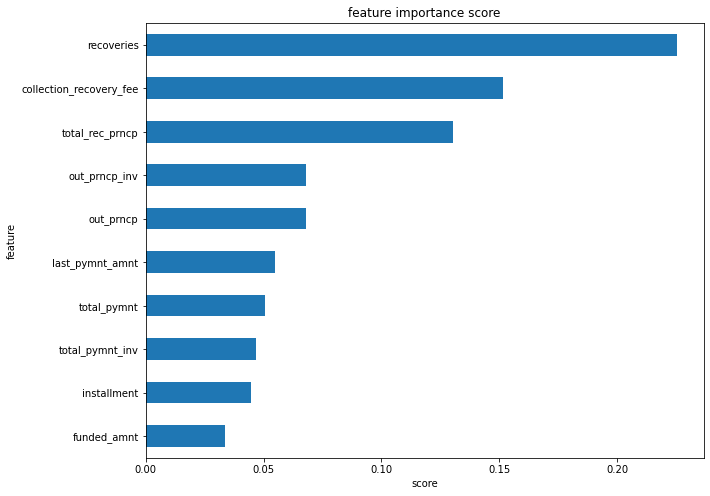

In [ ]:
show_feature_importance(rf_tuned)

In [ ]:
#cfm(y2_test1,y_pred) 

## Imbalance Dataset 80:20

In [ ]:
#check dataset
print(X2_train2.shape)
print(X2_test2.shape)

(373028, 55)
(93257, 55)


### Default Parameter

#### **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X2_train2,y2_train2)

y_train_pred = dt.predict(X2_train2)
y_pred = dt.predict(X2_test2)

eval_classification(dt, y_train_pred, y_pred, y2_train2, y2_test2)

Accuracy (Train Set): 1.00
Accuracy (Test Set): 0.97
Precision (Train Set): 1.00
Precision (Test Set): 0.84
Recall (Train Set): 1.00
Recall (Test Set): 0.86
F1-Score (Train Set): 1.00
F1-Score (Test Set): 0.85
AUC (Train Set): 1.00
AUC (Test Set): 0.92


In [ ]:
#cfm(y2_test2,y_pred)

#### **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1)
rf.fit(X2_train2, y2_train2)

y_train_pred = rf.predict(X2_train2)
y_pred = rf.predict(X2_test2)

eval_classification(rf, y_train_pred, y_pred, y2_train2, y2_test2)

Accuracy (Train Set): 1.00
Accuracy (Test Set): 0.98
Precision (Train Set): 1.00
Precision (Test Set): 1.00
Recall (Train Set): 1.00
Recall (Test Set): 0.84
F1-Score (Train Set): 1.00
F1-Score (Test Set): 0.91
AUC (Train Set): 1.00
AUC (Test Set): 0.92


In [ ]:
#cfm(y2_test2,y_pred)

### Hyperparameter Tuning

#### **Decision Tree**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np

hyperparameters = dict(max_depth=[5,10,25,50], 
                       min_samples_split=[5,10,25,50,100], 
                       min_samples_leaf=[25,50,100,125],
                       max_features=['auto','sqrt','log2']
                    )

dt = DecisionTreeClassifier(random_state=1)
dt_tuned = RandomizedSearchCV(dt, hyperparameters, cv=5, random_state=1, scoring='recall')
dt_tuned.fit(X2_train2, y2_train2)

y_train_pred = dt_tuned.predict(X2_train2)
y_pred = dt_tuned.predict(X2_test2)

eval_classification(dt_tuned, y_train_pred, y_pred, y2_train2, y2_test2)

#### **Random Forest**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#List Hyperparameters yang akan diuji
hyperparameters = dict(
                       #n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)],
                       #bootstrap = [True],
                       #criterion = ['gini','entropy'],
                       max_depth=[5,10,25,50], 
                       min_samples_split=[5,10,25,50,100], 
                       min_samples_leaf=[25,50,100,125],
                       max_features = ['auto', 'sqrt'])

rf = RandomForestClassifier(random_state=1)
rf_tuned = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=1, scoring='recall')
rf_tuned.fit(X2_train2,y2_train2)

y_train_pred = rf_tuned.predict(X2_train2)
y_pred = rf_tuned.predict(X2_test2)

eval_classification(rf_tuned, y_train_pred, y_pred, y2_train2, y2_test2)

In [ ]:
#cfm(y2_test2,y_pred)

# Best Model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Function Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

def eval_classification(model,  y_train_pred, y_test_pred, y_train, y_test):
    print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_train_pred))
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_test_pred))
    print("Precision (Train Set): %.2f" % precision_score(y_train, y_train_pred, zero_division=0))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_test_pred, zero_division=0))
    print("Recall (Train Set): %.2f" % recall_score(y_train, y_train_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_test_pred))
    print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_train_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_test_pred))
    
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred, pos_label=1) # pos_label: label yang kita anggap positive
    print("AUC (Train Set): %.2f" % auc(fpr, tpr))
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred, pos_label=1) # pos_label: label yang kita anggap positive
    print("AUC (Test Set): %.2f" % auc(fpr, tpr))

# confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
def cfm(y_test,y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,6))
    sns.set(font_scale = 1.5)
    ax = sns.heatmap(cf_matrix, annot=True,fmt = 'd')
    plt.title('Confusion Matrix From Test Set',fontsize=18)
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')
    plt.show()

In [ ]:
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)#.best_estimator_
    ax = feat_importances.nlargest(10).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()
    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])

In [ ]:
X2_train2 = pd.read_csv('/content/drive/MyDrive/Rakamin Academy/JAP/Virtual Internship Program 2/dataset/X2_train2.csv')
X2_test2 = pd.read_csv('/content/drive/MyDrive/Rakamin Academy/JAP/Virtual Internship Program 2/dataset/X2_test2.csv')
y2_train2 =pd.read_csv('/content/drive/MyDrive/Rakamin Academy/JAP/Virtual Internship Program 2/dataset/y2_train2.csv')
y2_test2 =pd.read_csv('/content/drive/MyDrive/Rakamin Academy/JAP/Virtual Internship Program 2/dataset/y2_test2.csv')

In [ ]:
y2_train2 = list(y2_train2['0'])
y2_test2 = list(y2_test2['0'])

## Best Model Using All Features

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_best = RandomForestClassifier(random_state=1,
                                 max_depth=25,
                                 min_samples_split=50,
                                 min_samples_leaf=50)
rf_best.fit(X2_train2,y2_train2)

y_train_pred_best = rf_best.predict(X2_train2)
y_pred_best = rf_best.predict(X2_test2)

eval_classification(rf_best, y_train_pred_best, y_pred_best, y2_train2, y2_test2)

Accuracy (Train Set): 0.98
Accuracy (Test Set): 0.98
Precision (Train Set): 1.00
Precision (Test Set): 1.00
Recall (Train Set): 0.81
Recall (Test Set): 0.81
F1-Score (Train Set): 0.89
F1-Score (Test Set): 0.89
AUC (Train Set): 0.90
AUC (Test Set): 0.90


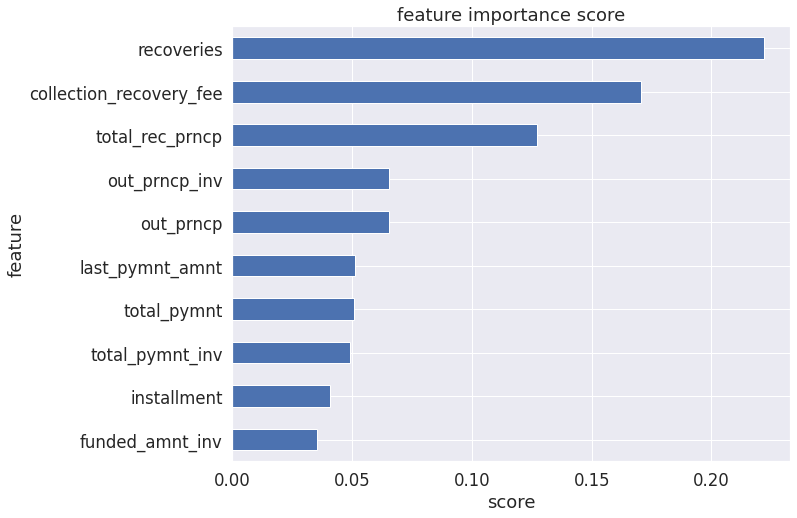

In [ ]:
feat_importances = pd.Series(rf_best.feature_importances_, index=X2_test2.columns)#.best_estimator_
ax = feat_importances.nlargest(10).plot(kind='barh', figsize=(10, 8))
ax.invert_yaxis()
plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')
plt.show()

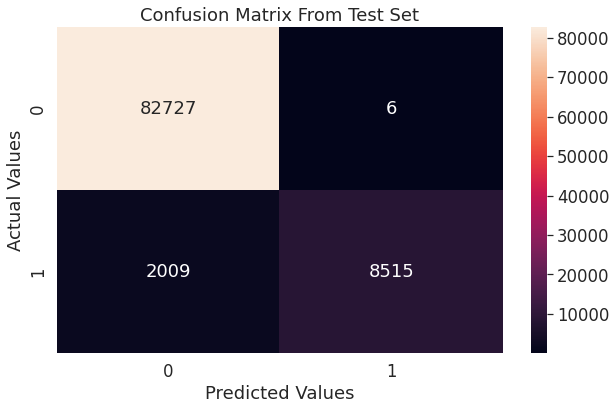

In [ ]:
cfm(y2_test2,y_pred_best)

## Best model using top 10 features

Mengambil 10 feature teratas

In [ ]:
a = feat_importances.sort_values(ascending=False).reset_index()
a = a[a.index<10]
b = list(a['index'])
len(b)

10

In [ ]:
b

['recoveries',
 'collection_recovery_fee',
 'total_rec_prncp',
 'out_prncp_inv',
 'out_prncp',
 'last_pymnt_amnt',
 'total_pymnt',
 'total_pymnt_inv',
 'installment',
 'funded_amnt_inv']

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_best1 = RandomForestClassifier(random_state=1,
                                 max_depth=25,
                                 min_samples_split=50,
                                 min_samples_leaf=50)
rf_best1.fit(X2_train2[b],y2_train2)

y_train_pred_best1 = rf_best1.predict(X2_train2[b])
y_pred_best1 = rf_best1.predict(X2_test2[b])

eval_classification(rf_best1, y_train_pred_best1, y_pred_best1, y2_train2, y2_test2)

Accuracy (Train Set): 0.98
Accuracy (Test Set): 0.98
Precision (Train Set): 1.00
Precision (Test Set): 1.00
Recall (Train Set): 0.83
Recall (Test Set): 0.83
F1-Score (Train Set): 0.91
F1-Score (Test Set): 0.91
AUC (Train Set): 0.92
AUC (Test Set): 0.92


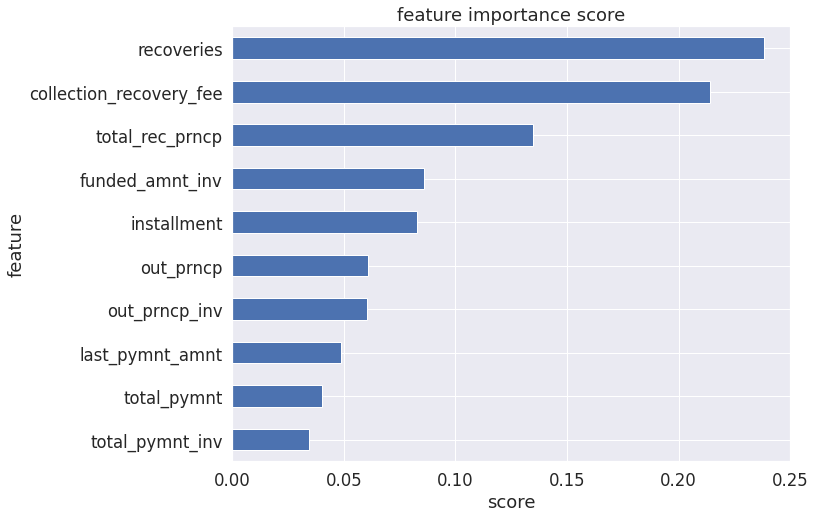

In [ ]:
feat_importances = pd.Series(rf_best1.feature_importances_, index=X2_test2[b].columns)#.best_estimator_
ax = feat_importances.nlargest(10).plot(kind='barh', figsize=(10, 8))
ax.invert_yaxis()
plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')
plt.show()

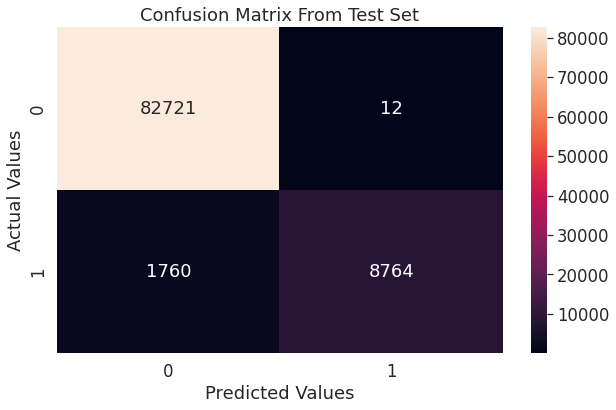

In [ ]:
cfm(y2_test2,y_pred_best1)

In [ ]:
c = X2_test2.copy()
c['target'] = y2_test2.copy()

In [ ]:
b = ['target','recoveries',
 'collection_recovery_fee',
 'total_rec_prncp',
 'out_prncp_inv',
 'out_prncp',
 'last_pymnt_amnt',
 'total_pymnt',
 'total_pymnt_inv',
 'installment',
 'funded_amnt_inv']

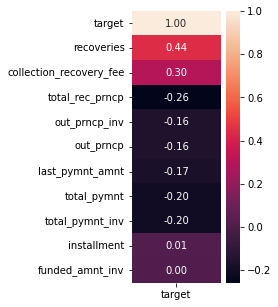

In [ ]:
plt.figure(figsize=(2,5))
sns.heatmap(c[b].corr()[['target']],annot=True,fmt='.2f')
plt.show()